# Edge Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from skimage.transform import resize
import imutils
from fastai.vision import *
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from scipy import ndimage
import sys
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from IPython.display import clear_output
import time
import bisect as bi

from helper_functions import *

In [3]:
path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_trained_model = path/'vocal_cords_and_rings_data/data/models'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()

num_classes = 4 #everything_else, vocal_cords, tracheal_rings, bifurcation

DEBUG_MODE = False

## Set up learner

In [4]:
learn = load_learner(path_trained_model, 'stage-2-big-0614-rn101.pkl')

In [20]:
def inference(frame):
    '''
    All the steps, one by one:
    
    frame_rgb = frame[...,::-1] #convert bgr to rgb

    t = Image(pil2tensor(PIL.Image.fromarray(frame_rgb).convert("RGB"), np.float32).div_(255))
    prediction = learn.predict(t)
    p = prediction[1].squeeze() #prediction data

    mask = np.array(p).astype(np.uint8)
    '''
    return np.array(
        learn.predict(Image(pil2tensor(PIL.Image.fromarray(frame[...,::-1]).convert("RGB"), np.float32).div_(255)))[1].squeeze()
        ).astype(np.uint8)

def unwrap_image(mask):
    
    ####### Find centroid of bifurcation#####
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    labels = get_blobs(mask,imshow=False)
    thresh = labels[3]
    thresh = img_as_uint(thresh*100)

    if len(np.where( thresh > 0 )[0]):
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX = 125
        cY = 150
        
    ###### endof find centre ############
    
    value = np.sqrt(((mask.shape[0]/2.0)**2.0)+((mask.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(mask.astype(np.float32),(cX,cY), value, cv2.WARP_FILL_OUTLIERS).astype(np.uint8)[:,:,0]
    
    return polar_image

def find_posterior_region(mask, prev_posterior_angles=None, posterior_region_ctr=0):
    if len(mask.shape)>2:
        raise Exception('Mask should be grayscale image.')
    
    posterior_region_ctr+=1
    
    # Find anterior and posterior parts of trachea
    histogram = np.sum((mask==1).astype(np.uint8), axis=1)#row-wise sums
    region, posterior_angle = longest_contiguous_region(histogram < 5, histogram)
    
    if prev_posterior_angles is not None:
        #Average previous angles
        prev_posterior_angles[posterior_region_ctr%len(prev_posterior_angles)]=posterior_angle
        posterior = int(np.average(prev_posterior_angles))
        
        return posterior, prev_posterior_angles, posterior_region_ctr

    return posterior_angle, None, None

def get_posterior_corrected_frame(mask, posterior):
    temp = mask[0:posterior,0:]
    return np.concatenate((mask[posterior:,0:],temp))

In [21]:
class Tracker():
    
    def __init__(self, init_frame=None, _verbose=False):
#         import pdb; pdb.set_trace()
        self.mid_blob_tracks = []
        self.mid_prev=[]
        self.verbose=_verbose
        mask_continuous=init_frame

        blobs_prev = get_blobs_single_class(mask_continuous==1, label_value=255)
        
        self.mid_blob_tracks = []
        for m in blobs_prev:
            if blob_area(m[112:122:])>0:
                M = cv2.moments((m[112:122:]>0).astype(np.uint8))
                cX = int(M["m10"] / M["m00"])
                self.mid_blob_tracks.append([cX])
        self.mid_blob_tracks.sort(reverse=True)
        mid_temp = get_middle_section(blobs_prev, collapse_channels=False)
        
        self.mid_prev=[]
        for mid in mid_temp:
            if blob_area(mid)>0:
                self.mid_prev.append(mid)
    
    def iterate(self, new_frame, ring_value=1):
        img = new_frame==ring_value
        
        #Find all blobs in current frame
        blobs_current = get_blobs_single_class(img, label_value=255)
        mid_temp = get_middle_section(blobs_current, collapse_channels=False)
        mid_new = []
        for mid in mid_temp:
            if blob_area(mid)>0:
                mid_new.append(mid)
                
        #Correlate children to parent blobs
        # blobs_new has the joined blobs with indices corresponding to their parents
#         import pdb; pdb.set_trace()
        blobs_new, orphans = correlate_blobs(mid_new, self.mid_prev, orphan_min_area=50)
        if blobs_new is None:
            print("EMPTY!!")
        
        #Add orphans to blobs_prev, so they can become parents in the next iteration
        #Note: this happens AFTER children have already found their parents
        self.mid_prev = []
        for blob_ in blobs_new:
            if blob_area(blob_[0])>0:
                self.mid_prev.append(blob_[0])
        #debug check
        for en, bl in enumerate(self.mid_prev):
            if blob_area(bl)<1:
                print("Empty blob at mid_prev[{}]".format(en))

        orphan_imgs = [np.array(o[0]).astype(np.uint8) for o in orphans]
        for o in orphan_imgs:
            if blob_area(o)>0:
                 self.mid_prev.append(o)
        
        for ctr,m in enumerate(blobs_new):
            M_prev = cv2.moments((m[1]>0).astype(np.uint8))
            cX_prev = int(M_prev["m10"] / M_prev["m00"])
            last_values = [track[-1] for track in self.mid_blob_tracks]

            if blob_area(m[0])>0: #non-empty child
                M = cv2.moments((m[0]>0).astype(np.uint8))
                cX = int(M["m10"] / M["m00"])        

                if cX_prev not in last_values:
                    raise Exception('Bad correlation. Parent not in list')

                self.mid_blob_tracks[last_values.index(cX_prev)].append(cX)
            else:#child is empty
                print("{} NO CHILD!!!".format(ctr))
                self.mid_blob_tracks[last_values.index(cX_prev)].append(None)
                
        #Insert at beginning (right-most blobs)
#         import pdb; pdb.set_trace()
        last_values = [track[-1] for track in self.mid_blob_tracks]
        try:
            start_none, end_none = get_non_None_section(last_values)
        except Exception as e:
            if hasattr(e, 'message'):
                print(e.message)
            else:
                print(e)
            #Return out of iterate() indicating failed tracking
            return False
            
        right_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) > last_values[start_none])

        for cX in right_orphans:
            last_values = [track[-1] for track in self.mid_blob_tracks]
            print("right_orphan: {}".format(cX))
            for j, val in enumerate(last_values):
                if val is not None:
                    if j==0 and cX > self.mid_blob_tracks[j][-1]:
                        self.mid_blob_tracks = [[cX]] + self.mid_blob_tracks
                        break
                    elif j!=0 and self.mid_blob_tracks[j-1][-1] is None and cX > self.mid_blob_tracks[j][-1]:
                        self.mid_blob_tracks[j-1].append(cX)
                    #break is intentionally outside of elif
                    break
        #Insert at end (left-most blobs)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        start_none, end_none = get_non_None_section(last_values)
        left_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[end_none])
        left_orphans.reverse()

        for cX in left_orphans:
            print("left_orphan: {}".format(cX))
            last_values = [track[-1] for track in self.mid_blob_tracks]
            for j, val in enumerate(reversed(last_values)):
                ctr = len(last_values)-1-j
                print("before None check {}, j={}, val={}".format(cX,j,val))
                if val is not None:
                    print("after None check {}".format(cX))
                    if ctr==len(last_values)-1 and cX < self.mid_blob_tracks[ctr][-1]: #i.e. last element in un-reversed last_values)
                        self.mid_blob_tracks = self.mid_blob_tracks+[[cX]]
                        print("first if {}".format(cX))
                        break

                    elif ctr!=len(last_values)-1 and self.mid_blob_tracks[ctr+1][-1] is None and cX < self.mid_blob_tracks[ctr][-1]:
                        self.mid_blob_tracks[ctr+1].append(cX)
                        print("second if {}".format(cX))
                    #break is intentionally outside of elif
                    break
                    
        #Must remove None islands before inserting a centre blob into tracks
        last_values = [track[-1] for track in self.mid_blob_tracks] #THIS ONE IS NEW - CHECK THAT IT WORKS IF NOT REMOVE LINE
        start_none, end_none = get_non_None_section(last_values)
        temp_tracks=[]
        idx_is_none = [val is None for val in [track[-1] for track in self.mid_blob_tracks][start_none: end_none+1]]
        for j,val in enumerate(idx_is_none):
            if val is False:
                temp_tracks=temp_tracks+[self.mid_blob_tracks[j+start_none]]
        self.mid_blob_tracks = self.mid_blob_tracks[:start_none]+temp_tracks+self.mid_blob_tracks[end_none+1:]

        #Insert at centre (in between other blobs in frame)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        start_none, end_none = get_non_None_section(last_values)
        centre_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[start_none] and get_centroid_x(o[0]) > last_values[end_none])
        
        for cX in centre_orphans:
            print("MIDDLE BLOB BEING INSERTED cX: {}".format(cX))
            last_values = [track[-1] for track in self.mid_blob_tracks][start_none: end_none+1]
            #must reverse list for insort to work properly (i.e. insort requires low to hi sorted)
            last_values.reverse()
            bi.insort(last_values, cX)
            last_values.reverse()
            idx = last_values.index(cX)+start_none
            self.mid_blob_tracks=self.mid_blob_tracks[:idx]+[[cX]]+self.mid_blob_tracks[idx:]
            
        
        last_values = [track[-1] for track in self.mid_blob_tracks]
        
#         import pdb; pdb.set_trace()
        cimg = plot_blobs_in_order([b[0] for b in blobs_new if blob_area(b[0])>0],blobs_current,last_values,plot=True)
        
        if self.verbose:
            fig=plt.figure(figsize=(24,24))
            columns = 3
            rows = 1
            
            imgs = [intersect,img, img-intersect]
            for i in range(1, columns*rows +1):
                fig.add_subplot(rows, columns, i)
                plt.imshow(imgs[i-1])
            plt.show()
            
        return True #successful tracking

In [22]:
def correlate_blobs(new_blobs, prev_blobs, percent_overlap_thresh=0.75, child_area_thresh=1.5, orphan_min_area=50):
    """
    Link parent blobs from prev_blobs to children blobs from new_blobs
    constraints:

    0) children can only have one parent. parents can have multiple children

    1) children must have a large enough intersection with their parent

    2) children must be smaller than their parents (they are allowed to be larger up to a certain threshold)
    if a potential child has a strong correlation to a given potential parent (large intersection), it is only
    considered a child if child_area < parent_area*thresh (where thresh is >= 1)
    else if a potential child has a strong correlation to a given potential parent, and it doesn't meet the area criteria,
    a new track is created for it and it is parentless (TODO: consider going "back" in the tree and grouping previous blobs
    and considering them as a single blob so that the area criteria is met. rn thinking not needed)

    Args:
        new_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in current 
                   frame (see get_blobs_single_class() )
        prev_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in previous
                   frame (see get_blobs_single_class() )
        percent_overlap_thresh (default: 0.75): minimum amount that
                   child must overlap with parent to be considered
                   a child
        child_area_thresh (default: 1.5): child can be up to
                   child_area_thresh times bigger than its parent
                   to be considered a child
        orphan_min_area (default: 50): minimum area for a parentless
                   blob to be added to orphan list. All orphans with
                   less than orphan_min_area will be disregarded
                   
    Returns:
        family, orphans
        
        family: list of tuples of (child_blob, parent_blob) i.e. the
                actual frames are tuple[0] and tuple[1]
                If a parent has no children, entry will be (zero_arr, parent_blob)
                len of family is num_parent_blob
                
        orphans: list of tuples of (orphan_blob, None) i.e. the actual
                frame is tuple[0], and tuple[1] is None
                len of orphans is the number of orphans in current frame
                   
    """
    parent_to_children = {} #key is the parent ID, value is the child ID
    orphans = [] # IDs of blobs without parents
    
    #Make all children empty lists
    for p in range(0, len(prev_blobs)):
        parent_to_children[p] = [] 
    
    #Populate parent_to_child dict (children pick their parents)
    for c in range(0, len(new_blobs)):
        nblob = new_blobs[c]
   
        max_intercept = 0
        max_intercept_p = -1
                        
        for p in range(0,len(prev_blobs)):
            pblob = prev_blobs[p]
            intersect = cv2.bitwise_and(nblob, pblob)
            
            if blob_area(intersect) > max_intercept:
                max_intercept = blob_area(intersect)
                max_intercept_p = p
          
        if max_intercept > 0 and blob_area(nblob) < blob_area(prev_blobs[max_intercept_p])*child_area_thresh and max_intercept > blob_area(nblob)*0.10:
            parent_to_children[max_intercept_p].append(c) #Huzzah! Child picked a parent
#             print("nparents {} -child {} picked {} ".format(len(prev_blobs), c, max_intercept_p))
        else: #Child has no parent
            orphans.append(c)
                    
    #Join children blobs (if they belong to the same parent) to deal with blob separation
    #and add (child,parent) tuple to a "family" list
#     joined_blobs = {} # len(new_blobs) == len(prev_blobs)+len(orphans)
    family = []
    
    for p in range (0, len(parent_to_children)):
#         joined_blobs[p] = []
        if len(parent_to_children[p])>1: #parent has more than one child
            joined_blob = np.zeros_like(prev_blobs[0])
            for child_blob_index in parent_to_children[p]:
                joined_blob = cv2.bitwise_or(new_blobs[child_blob_index], joined_blob)
#                 print("JOINED BLOB TYPE {}".format(joined_blob.dtype))
#                 print("joined_blobs shape: {}".format(joined_blob.shape))
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
            
        elif len(parent_to_children[p])==1:
            joined_blob = new_blobs[parent_to_children[p][0]]
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
        else: #do nothing -> i.e. a parent that didn't have a child will die
            family.append((np.zeros_like(prev_blobs[p]),prev_blobs[p]))
    
    #Add orphans to the future parents list, so they can have children
    orphan_imgs = []
    for o in orphans:
        if np.count_nonzero(new_blobs[o]) > orphan_min_area:
            orphan_imgs.append((new_blobs[o], None))
        
    
    return family, orphan_imgs #joined_blobs has prev_parents+orphans number of channels, each channel being an individual blob

In [23]:
def collapse_channels(blobs):
    """
    Collapses all image channels into a single frame

    Reverses get_blobs_single_class

    Args:
        blobs: multi-channel image
    Returns:
        all blobs in a single frame
    """
    blobs_new_frame = np.zeros_like(blobs[0])

    for b in blobs:
        blobs_new_frame = np.array(blobs_new_frame) | np.array(b)
    return blobs_new_frame

def get_centroid_x(o):
    if blob_area(o)>0:
        M = cv2.moments((o>0).astype(np.uint8))
        cX = int(M["m10"] / M["m00"])
        return cX
    
def get_non_None_section(last_values):
    # No blobs had children. Lost tracking
    if last_values.count(None) == len(last_values):
        raise Exception('Error tracking. Was not able to correlate any blobs. Must reset')
    
    start_none = 0
    end_none = len(last_values)-1
    for j, val in enumerate(last_values):
        if val is not None:
            start_none=j
            break
            
    for j, val in enumerate(reversed(last_values)):
        ctr=len(last_values)-1-j
        if val is not None and ctr >= start_none:
            end_none=ctr
            break
    return start_none, end_none

def plot_blobs_in_order(mid_blobs, blobs, last_values, plot=True):
    if len(mid_blobs)>len(blobs):
        print("Error: Mismatched midblobs len len ({}) and blobs ({}).".format(len(mid_blobs), len(blobs)))
        return
    
    output_frame = np.zeros_like(blobs[0])
    for mb in mid_blobs:
        ID = last_values.index(get_centroid_x(mb))
        for i, b in enumerate(blobs):
            output_frame = (output_frame) | (b/np.max(b)*20).astype(np.uint8)
            if blobs_intersect(mb,b[112:122:].astype(np.uint8)):
                output_frame = (output_frame) | (b/np.max(b)*(ID+1)*25).astype(np.uint8)
                del blobs[i]
                break
    numbers_frame = np.zeros((224,224), np.uint8)
    
    start_none, end_none = get_non_None_section(last_values)
    for cX in last_values[start_none: end_none+1]:
        cv2.putText(numbers_frame , "{}".format(last_values.index(cX)), (cX, 120), cv2.FONT_HERSHEY_SIMPLEX,0.3, 255, 1)
    output_frame = (output_frame) | (numbers_frame).astype(np.uint8)
    
    if plot: pltimg(output_frame)
    
    return output_frame

## Setup Video

In [24]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 45
#end time for annotation (in seconds)
end_time_s = 54
mask_timeline = []
clean_timeline = []
clean_flattened_timeline = []
frame_timeline = []

# debug only
eroded_timeline = []
###ENDOF PARAMS###

#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
for _ in range(0,72):
    ret, frame = cap.read()
ret, frame = cap.read() #frame is uint8

Cap fps: 29.97002997002997


Starting!
ctr 1
(dtype('uint8'), True, (224, 224))


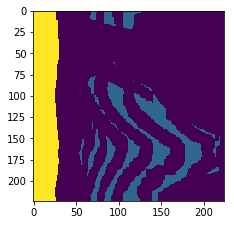

Prev post ang: [56, 50, 56, 56], posterior: 54,  ctr:1
DTYPE: (224, 224)
ctr 2
(dtype('uint8'), True, (224, 224))


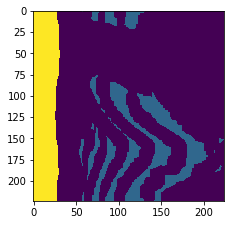

Prev post ang: [56, 50, 50, 56], posterior: 53,  ctr:2


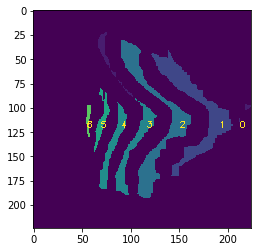

DTYPE: (224, 224)
ctr 3
(dtype('uint8'), True, (224, 224))


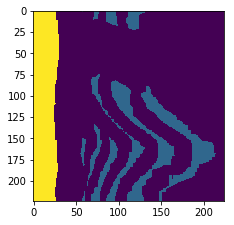

Prev post ang: [56, 50, 50, 50], posterior: 51,  ctr:3
2 NO CHILD!!!


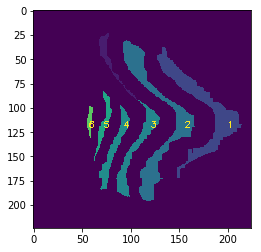

DTYPE: (224, 224)
ctr 4
(dtype('uint8'), True, (224, 224))


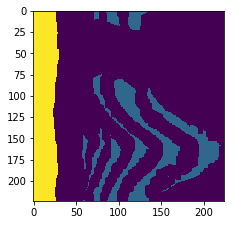

Prev post ang: [49, 50, 50, 50], posterior: 49,  ctr:4


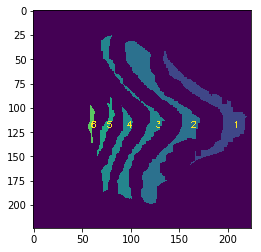

DTYPE: (224, 224)
ctr 5
(dtype('uint8'), True, (224, 224))


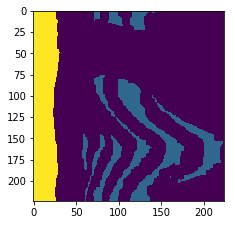

Prev post ang: [49, 50, 50, 50], posterior: 49,  ctr:5


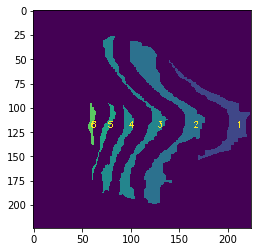

DTYPE: (224, 224)
ctr 6
(dtype('uint8'), True, (224, 224))


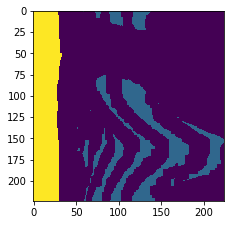

Prev post ang: [49, 50, 50, 50], posterior: 49,  ctr:6


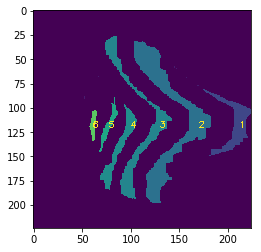

DTYPE: (224, 224)
ctr 7
(dtype('uint8'), True, (224, 224))


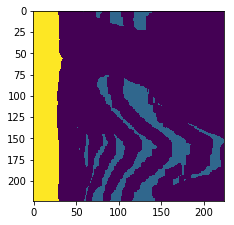

Prev post ang: [49, 50, 50, 50], posterior: 49,  ctr:7


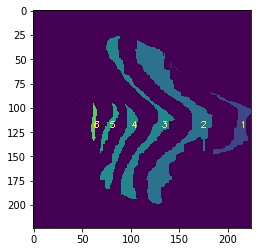

DTYPE: (224, 224)
ctr 8
(dtype('uint8'), True, (224, 224))


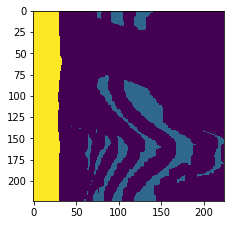

Prev post ang: [50, 50, 50, 50], posterior: 50,  ctr:8


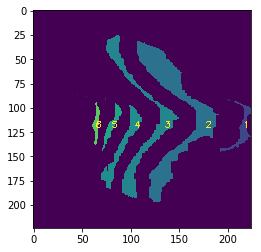

DTYPE: (224, 224)
ctr 9
(dtype('uint8'), True, (224, 224))


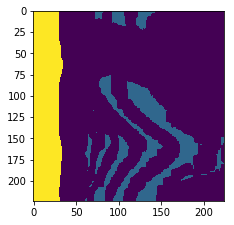

Prev post ang: [50, 49, 50, 50], posterior: 49,  ctr:9


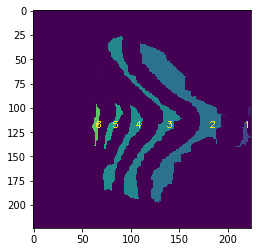

DTYPE: (224, 224)
ctr 10
(dtype('uint8'), True, (224, 224))


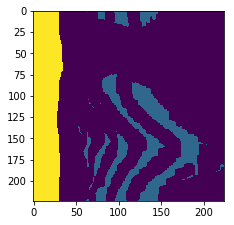

Prev post ang: [50, 49, 47, 50], posterior: 49,  ctr:10
1 NO CHILD!!!


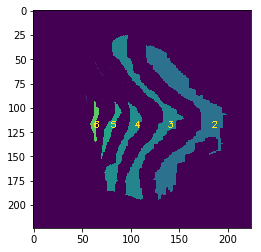

DTYPE: (224, 224)
ctr 11
(dtype('uint8'), True, (224, 224))


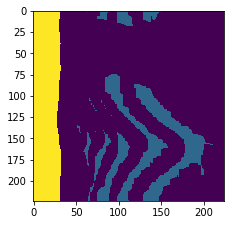

Prev post ang: [50, 49, 47, 47], posterior: 48,  ctr:11


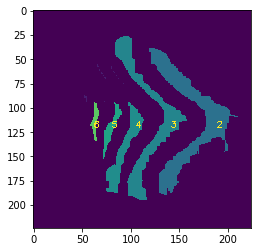

DTYPE: (224, 224)
ctr 12
(dtype('uint8'), True, (224, 224))


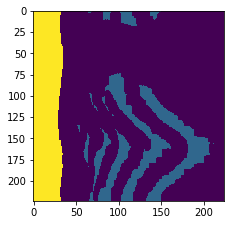

Prev post ang: [47, 49, 47, 47], posterior: 47,  ctr:12


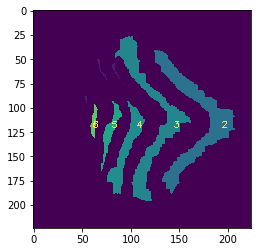

DTYPE: (224, 224)
ctr 13
(dtype('uint8'), True, (224, 224))


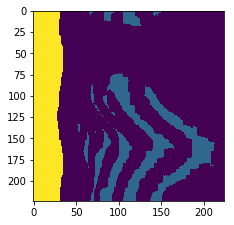

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:13


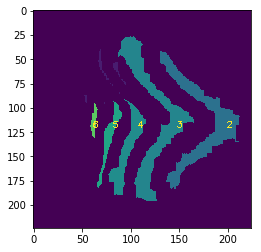

DTYPE: (224, 224)
ctr 14
(dtype('uint8'), True, (224, 224))


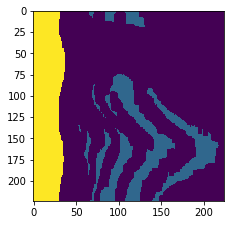

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:14


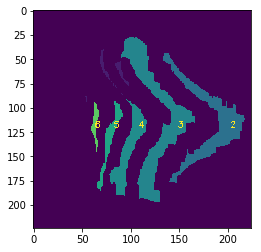

DTYPE: (224, 224)
ctr 15
(dtype('uint8'), True, (224, 224))


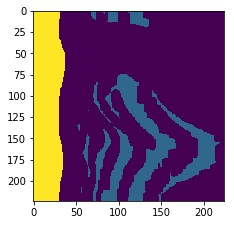

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:15


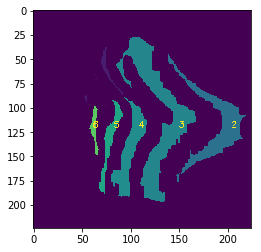

DTYPE: (224, 224)
ctr 16
(dtype('uint8'), True, (224, 224))


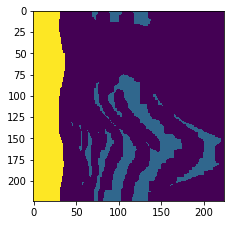

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:16


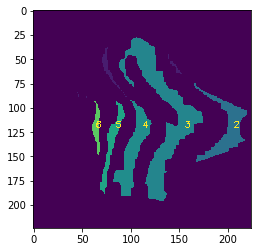

DTYPE: (224, 224)
ctr 17
(dtype('uint8'), True, (224, 224))


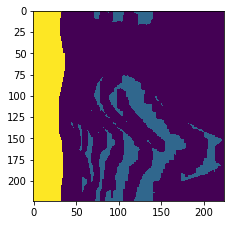

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:17


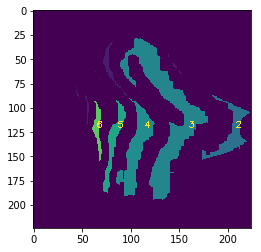

DTYPE: (224, 224)
ctr 18
(dtype('uint8'), True, (224, 224))


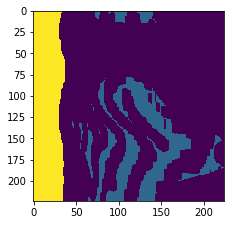

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:18


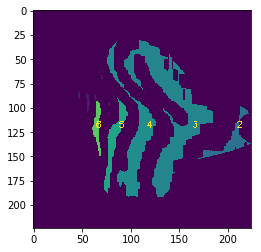

DTYPE: (224, 224)
ctr 19
(dtype('uint8'), True, (224, 224))


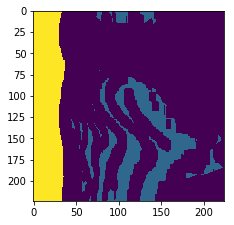

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:19


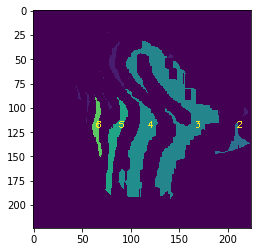

DTYPE: (224, 224)
ctr 20
(dtype('uint8'), True, (224, 224))


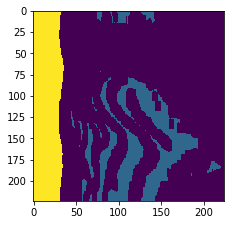

Prev post ang: [47, 47, 47, 47], posterior: 47,  ctr:20
0 NO CHILD!!!


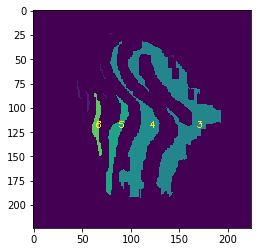

DTYPE: (224, 224)
ctr 21
(dtype('uint8'), True, (224, 224))


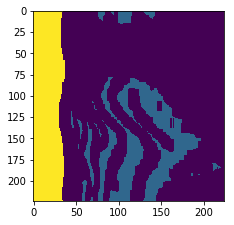

Prev post ang: [47, 46, 47, 47], posterior: 46,  ctr:21


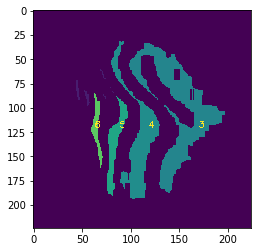

DTYPE: (224, 224)
ctr 22
(dtype('uint8'), True, (224, 224))


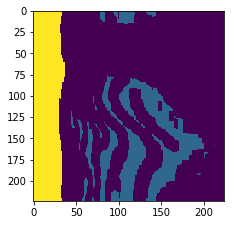

Prev post ang: [47, 46, 46, 47], posterior: 46,  ctr:22


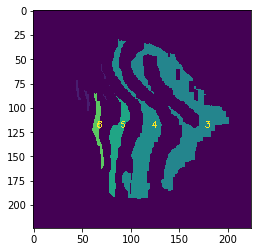

DTYPE: (224, 224)
ctr 23
(dtype('uint8'), True, (224, 224))


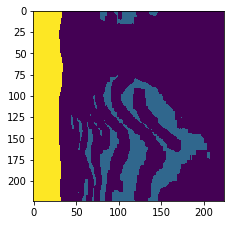

Prev post ang: [47, 46, 46, 47], posterior: 46,  ctr:23


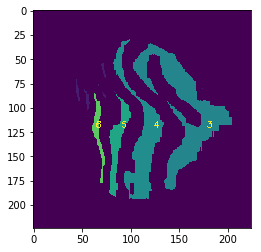

DTYPE: (224, 224)
ctr 24
(dtype('uint8'), True, (224, 224))


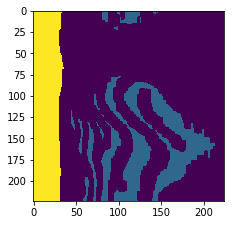

Prev post ang: [50, 46, 46, 47], posterior: 47,  ctr:24


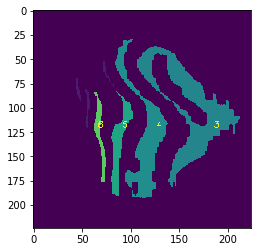

DTYPE: (224, 224)
ctr 25
(dtype('uint8'), True, (224, 224))


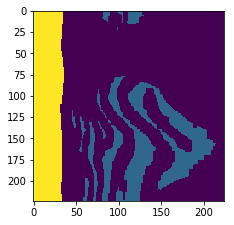

Prev post ang: [50, 46, 46, 47], posterior: 47,  ctr:25


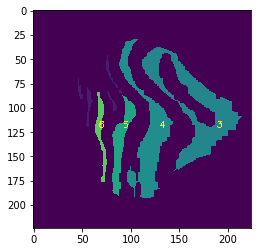

DTYPE: (224, 224)
ctr 26
(dtype('uint8'), True, (224, 224))


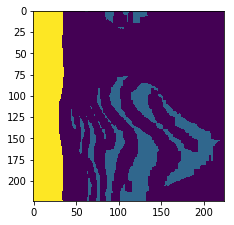

Prev post ang: [50, 46, 49, 47], posterior: 48,  ctr:26


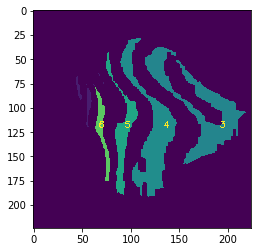

DTYPE: (224, 224)
ctr 27
(dtype('uint8'), True, (224, 224))


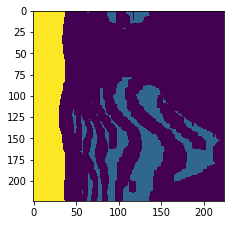

Prev post ang: [50, 46, 49, 47], posterior: 48,  ctr:27


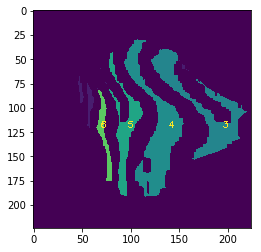

DTYPE: (224, 224)
ctr 28
(dtype('uint8'), True, (224, 224))


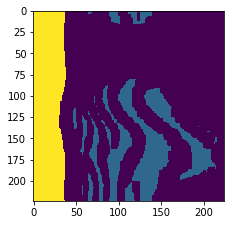

Prev post ang: [48, 46, 49, 47], posterior: 47,  ctr:28


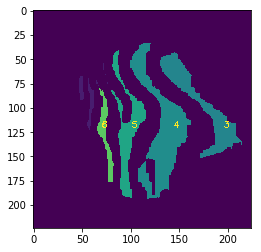

DTYPE: (224, 224)
ctr 29
(dtype('uint8'), True, (224, 224))


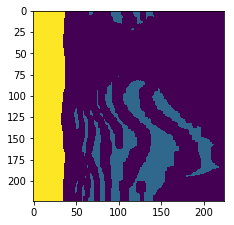

Prev post ang: [48, 49, 49, 47], posterior: 48,  ctr:29


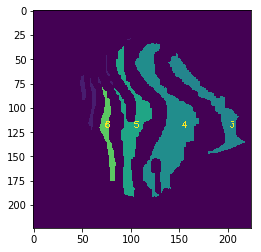

DTYPE: (224, 224)
ctr 30
(dtype('uint8'), True, (224, 224))


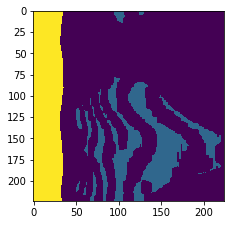

Prev post ang: [48, 49, 47, 47], posterior: 47,  ctr:30


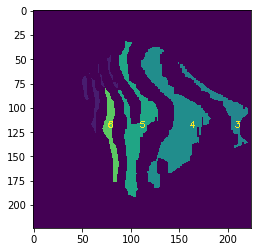

DTYPE: (224, 224)
ctr 31
(dtype('uint8'), True, (224, 224))


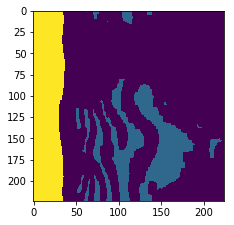

Prev post ang: [48, 49, 47, 48], posterior: 48,  ctr:31


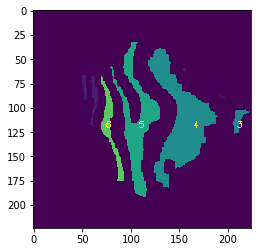

DTYPE: (224, 224)
ctr 32
(dtype('uint8'), True, (224, 224))


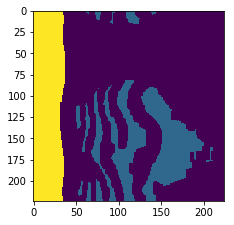

Prev post ang: [49, 49, 47, 48], posterior: 48,  ctr:32


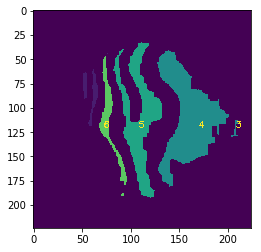

DTYPE: (224, 224)
ctr 33
(dtype('uint8'), True, (224, 224))


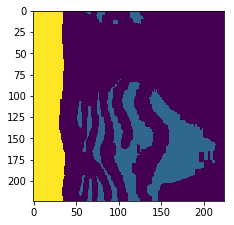

Prev post ang: [49, 50, 47, 48], posterior: 48,  ctr:33
1 NO CHILD!!!


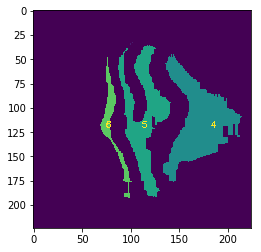

DTYPE: (224, 224)
ctr 34
(dtype('uint8'), True, (224, 224))


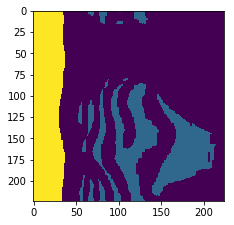

Prev post ang: [49, 50, 84, 48], posterior: 57,  ctr:34


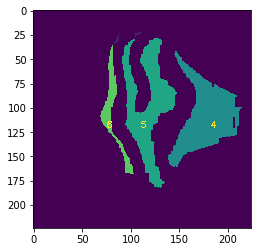

DTYPE: (224, 224)
ctr 35
(dtype('uint8'), True, (224, 224))


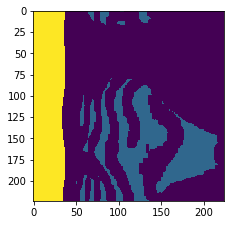

Prev post ang: [49, 50, 84, 84], posterior: 66,  ctr:35


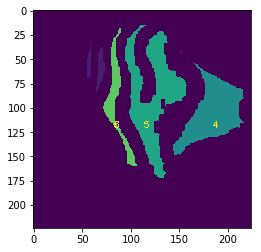

DTYPE: (224, 224)
ctr 36
(dtype('uint8'), True, (224, 224))


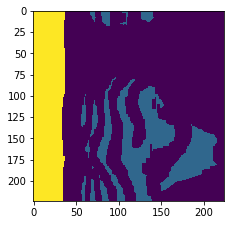

Prev post ang: [49, 50, 84, 84], posterior: 66,  ctr:36


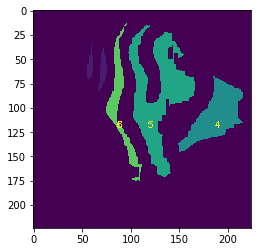

DTYPE: (224, 224)
ctr 37
(dtype('uint8'), True, (224, 224))


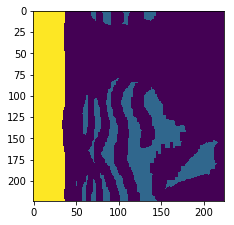

Prev post ang: [49, 83, 84, 84], posterior: 75,  ctr:37
2 NO CHILD!!!
left_orphan: 96
before None check 96, j=0, val=None
before None check 96, j=1, val=127
after None check 96
second if 96


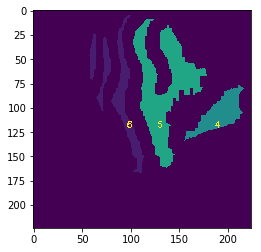

DTYPE: (224, 224)
ctr 38
(dtype('uint8'), True, (224, 224))


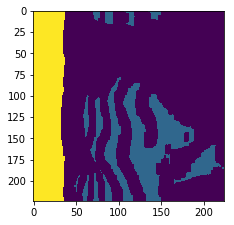

Prev post ang: [49, 83, 84, 84], posterior: 75,  ctr:38


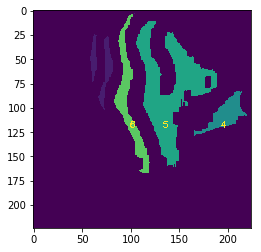

DTYPE: (224, 224)
ctr 39
(dtype('uint8'), True, (224, 224))


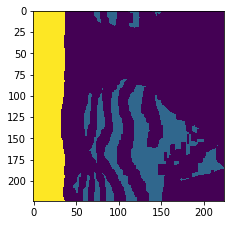

Prev post ang: [49, 83, 84, 50], posterior: 66,  ctr:39


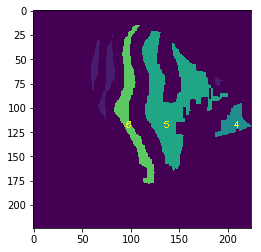

DTYPE: (224, 224)
ctr 40
(dtype('uint8'), True, (224, 224))


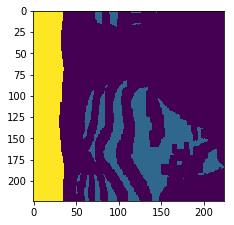

Prev post ang: [52, 83, 84, 50], posterior: 67,  ctr:40


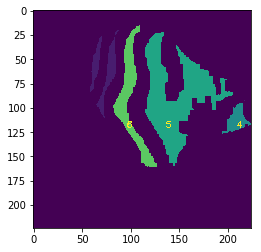

DTYPE: (224, 224)
ctr 41
(dtype('uint8'), True, (224, 224))


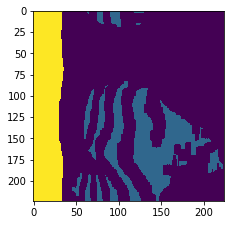

Prev post ang: [52, 50, 84, 50], posterior: 59,  ctr:41
0 NO CHILD!!!
MIDDLE BLOB BEING INSERTED cX: 141


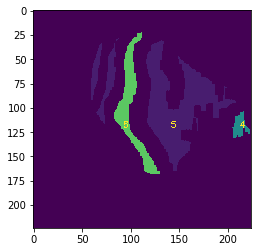

DTYPE: (224, 224)
ctr 42
(dtype('uint8'), True, (224, 224))


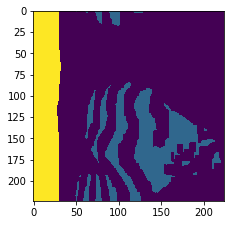

Prev post ang: [52, 50, 52, 50], posterior: 51,  ctr:42
left_orphan: 72
before None check 72, j=0, val=92
after None check 72
first if 72


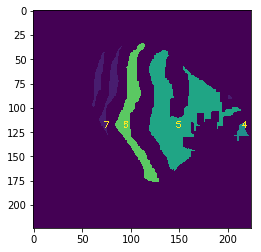

DTYPE: (224, 224)
ctr 43
(dtype('uint8'), True, (224, 224))


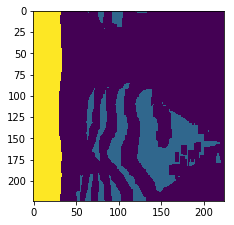

Prev post ang: [52, 50, 52, 53], posterior: 51,  ctr:43


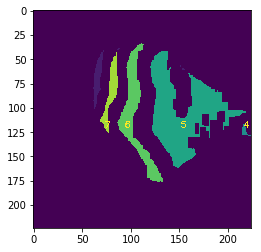

DTYPE: (224, 224)
ctr 44
(dtype('uint8'), True, (224, 224))


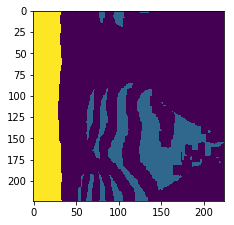

Prev post ang: [52, 50, 52, 53], posterior: 51,  ctr:44


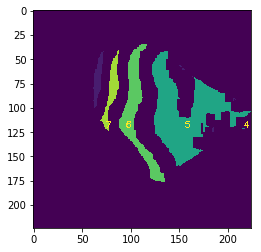

DTYPE: (224, 224)
ctr 45
(dtype('uint8'), True, (224, 224))


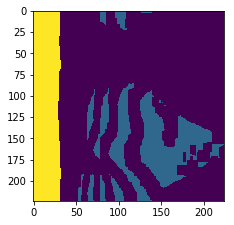

Prev post ang: [52, 55, 52, 53], posterior: 53,  ctr:45
0 NO CHILD!!!
right_orphan: 212


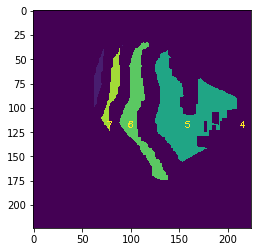

DTYPE: (224, 224)
ctr 46
(dtype('uint8'), True, (224, 224))


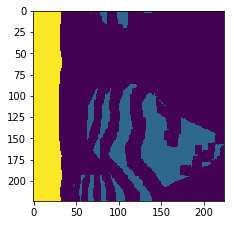

Prev post ang: [52, 55, 52, 53], posterior: 53,  ctr:46
3 NO CHILD!!!


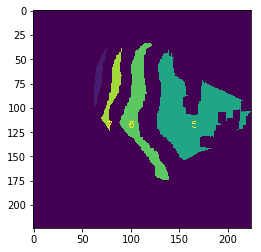

DTYPE: (224, 224)
ctr 47
(dtype('uint8'), True, (224, 224))


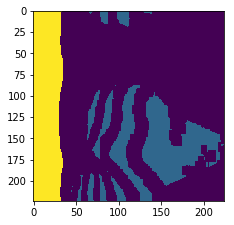

Prev post ang: [52, 55, 52, 53], posterior: 53,  ctr:47


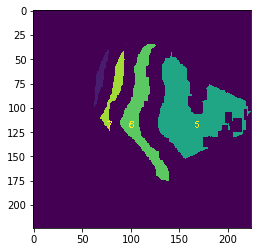

DTYPE: (224, 224)
ctr 48
(dtype('uint8'), True, (224, 224))


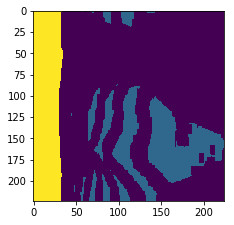

Prev post ang: [54, 55, 52, 53], posterior: 53,  ctr:48


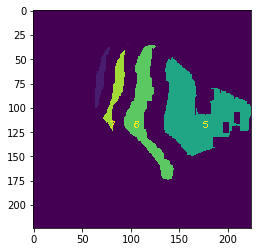

DTYPE: (224, 224)
ctr 49
(dtype('uint8'), True, (224, 224))


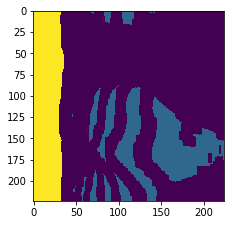

Prev post ang: [54, 53, 52, 53], posterior: 53,  ctr:49


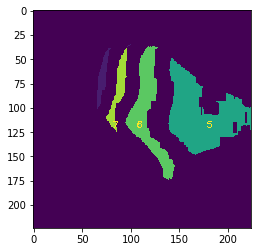

DTYPE: (224, 224)
ctr 50
(dtype('uint8'), True, (224, 224))


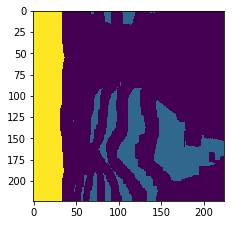

Prev post ang: [54, 53, 53, 53], posterior: 53,  ctr:50


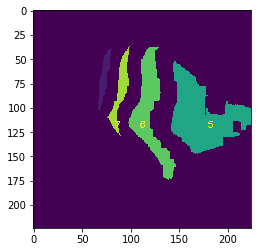

DTYPE: (224, 224)
ctr 51
(dtype('uint8'), True, (224, 224))


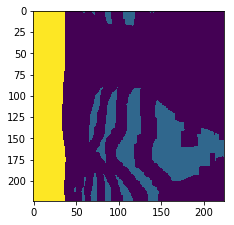

Prev post ang: [54, 53, 53, 54], posterior: 53,  ctr:51


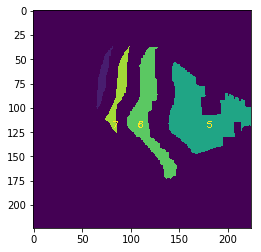

DTYPE: (224, 224)
ctr 52
(dtype('uint8'), True, (224, 224))


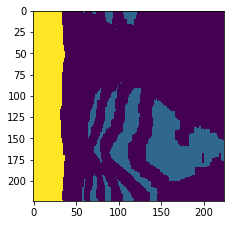

Prev post ang: [54, 53, 53, 54], posterior: 53,  ctr:52


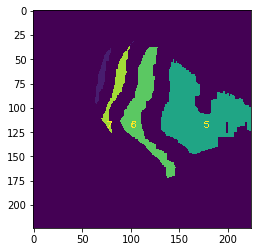

DTYPE: (224, 224)
ctr 53
(dtype('uint8'), True, (224, 224))


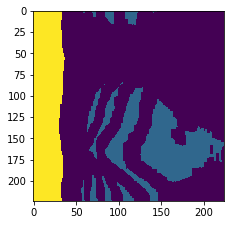

Prev post ang: [54, 54, 53, 54], posterior: 53,  ctr:53


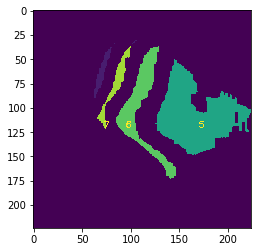

DTYPE: (224, 224)
ctr 54
(dtype('uint8'), True, (224, 224))


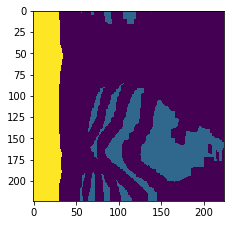

Prev post ang: [54, 54, 53, 54], posterior: 53,  ctr:54


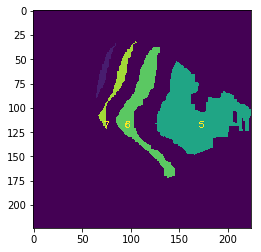

DTYPE: (224, 224)
ctr 55
(dtype('uint8'), True, (224, 224))


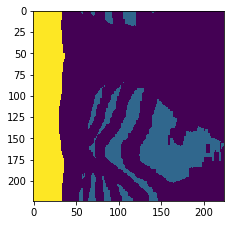

Prev post ang: [54, 54, 53, 55], posterior: 54,  ctr:55


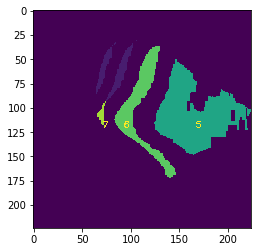

DTYPE: (224, 224)
ctr 56
(dtype('uint8'), True, (224, 224))


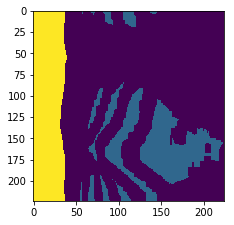

Prev post ang: [55, 54, 53, 55], posterior: 54,  ctr:56
2 NO CHILD!!!


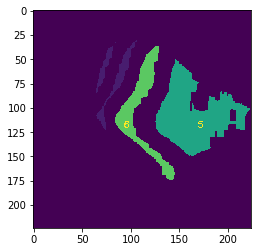

DTYPE: (224, 224)
ctr 57
(dtype('uint8'), True, (224, 224))


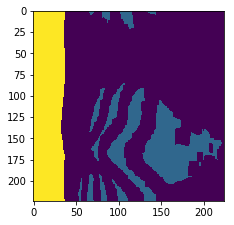

Prev post ang: [55, 56, 53, 55], posterior: 54,  ctr:57


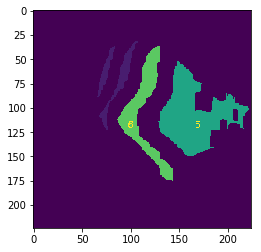

DTYPE: (224, 224)
ctr 58
(dtype('uint8'), True, (224, 224))


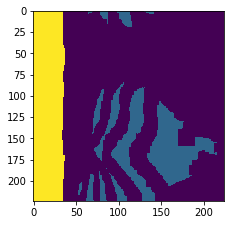

Prev post ang: [55, 56, 55, 55], posterior: 55,  ctr:58


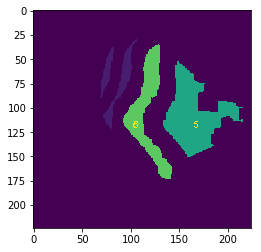

DTYPE: (224, 224)
ctr 59
(dtype('uint8'), True, (224, 224))


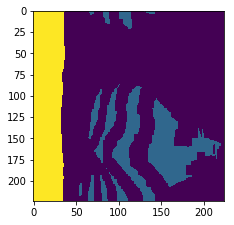

Prev post ang: [55, 56, 55, 55], posterior: 55,  ctr:59
left_orphan: 78
before None check 78, j=0, val=None
before None check 78, j=1, val=103
after None check 78
second if 78


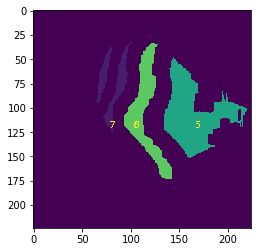

DTYPE: (224, 224)
ctr 60
(dtype('uint8'), True, (224, 224))


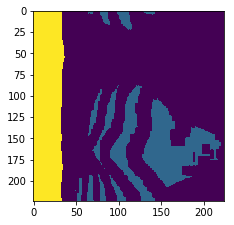

Prev post ang: [55, 56, 55, 55], posterior: 55,  ctr:60


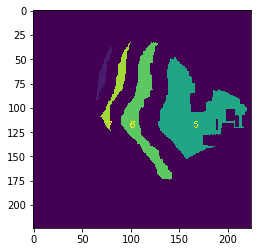

DTYPE: (224, 224)
ctr 61
(dtype('uint8'), True, (224, 224))


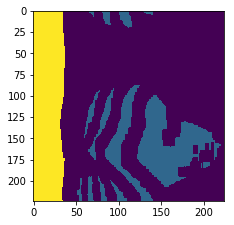

Prev post ang: [55, 54, 55, 55], posterior: 54,  ctr:61
2 NO CHILD!!!
left_orphan: 70
before None check 70, j=0, val=None
before None check 70, j=1, val=93
after None check 70
second if 70


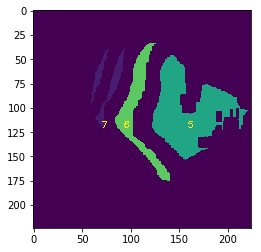

DTYPE: (224, 224)
ctr 62
(dtype('uint8'), True, (224, 224))


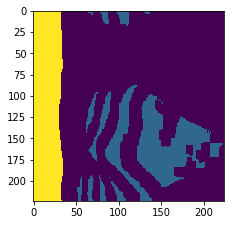

Prev post ang: [55, 54, 52, 55], posterior: 54,  ctr:62


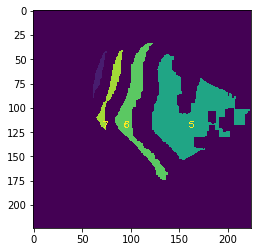

DTYPE: (224, 224)
ctr 63
(dtype('uint8'), True, (224, 224))


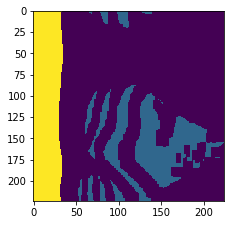

Prev post ang: [55, 54, 52, 54], posterior: 53,  ctr:63


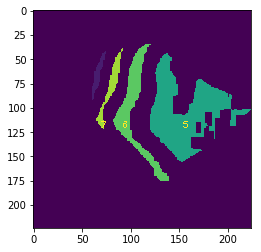

DTYPE: (224, 224)
ctr 64
(dtype('uint8'), True, (224, 224))


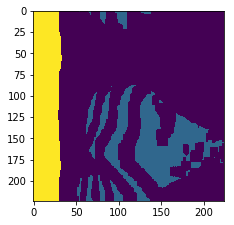

Prev post ang: [53, 54, 52, 54], posterior: 53,  ctr:64


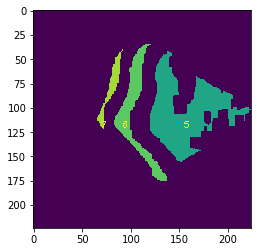

DTYPE: (224, 224)
ctr 65
(dtype('uint8'), True, (224, 224))


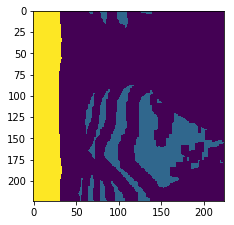

Prev post ang: [53, 53, 52, 54], posterior: 53,  ctr:65


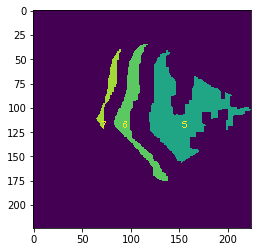

DTYPE: (224, 224)
ctr 66
(dtype('uint8'), True, (224, 224))


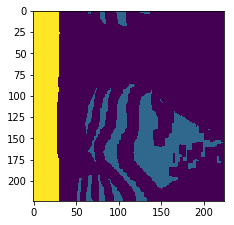

Prev post ang: [53, 53, 53, 54], posterior: 53,  ctr:66


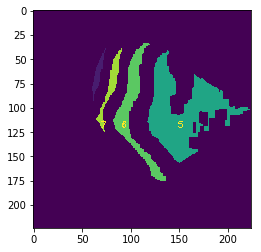

DTYPE: (224, 224)
ctr 67
(dtype('uint8'), True, (224, 224))


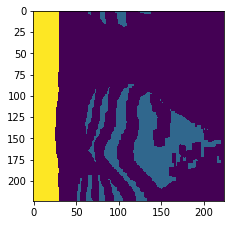

Prev post ang: [53, 53, 53, 89], posterior: 62,  ctr:67
right_orphan: 186


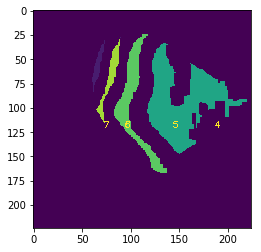

DTYPE: (224, 224)
ctr 68
(dtype('uint8'), True, (224, 224))


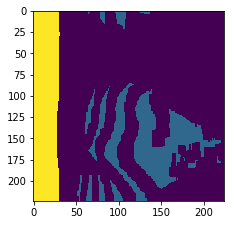

Prev post ang: [91, 53, 53, 89], posterior: 71,  ctr:68
2 NO CHILD!!!
3 NO CHILD!!!


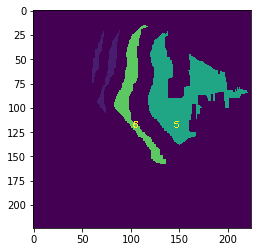

DTYPE: (224, 224)
ctr 69
(dtype('uint8'), True, (224, 224))


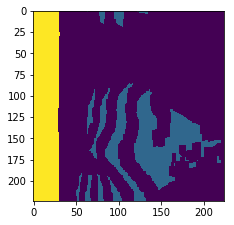

Prev post ang: [91, 52, 53, 89], posterior: 71,  ctr:69


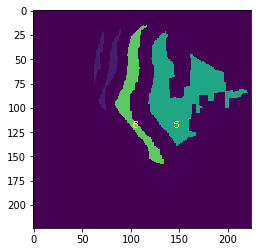

DTYPE: (224, 224)
ctr 70
(dtype('uint8'), True, (224, 224))


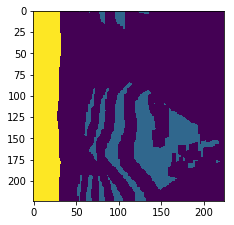

Prev post ang: [91, 52, 52, 89], posterior: 71,  ctr:70


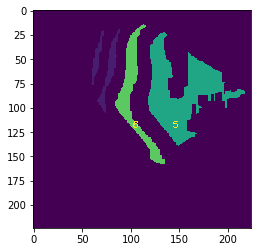

DTYPE: (224, 224)
ctr 71
(dtype('uint8'), True, (224, 224))


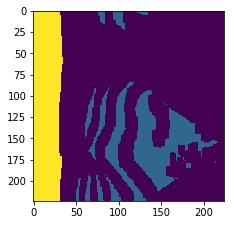

Prev post ang: [91, 52, 52, 91], posterior: 71,  ctr:71


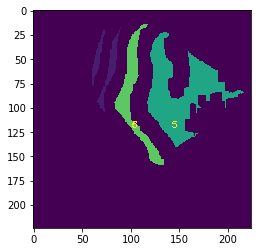

DTYPE: (224, 224)
ctr 72
(dtype('uint8'), True, (224, 224))


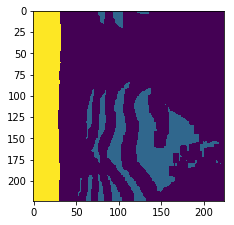

Prev post ang: [53, 52, 52, 91], posterior: 62,  ctr:72
1 NO CHILD!!!
right_orphan: 143


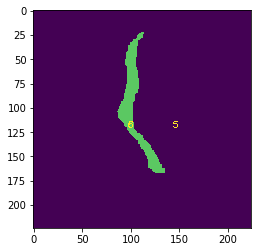

DTYPE: (224, 224)
ctr 73
(dtype('uint8'), True, (224, 224))


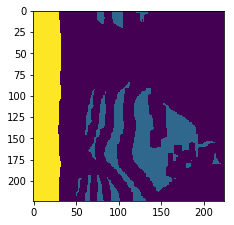

Prev post ang: [53, 54, 52, 91], posterior: 62,  ctr:73


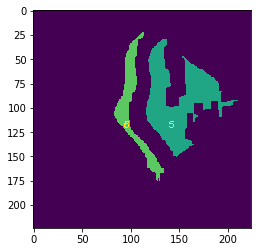

DTYPE: (224, 224)
ctr 74
(dtype('uint8'), True, (224, 224))


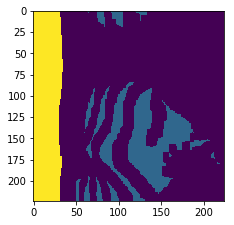

Prev post ang: [53, 54, 90, 91], posterior: 72,  ctr:74


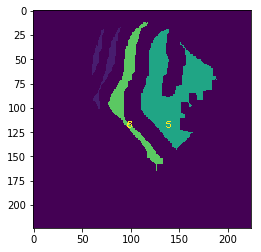

DTYPE: (224, 224)
ctr 75
(dtype('uint8'), True, (224, 224))


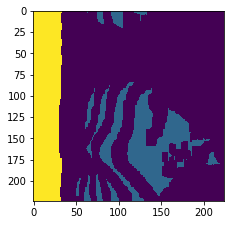

Prev post ang: [53, 54, 90, 90], posterior: 71,  ctr:75


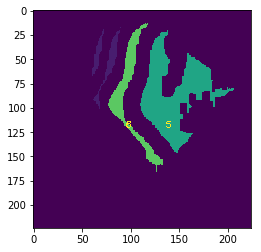

DTYPE: (224, 224)
ctr 76
(dtype('uint8'), True, (224, 224))


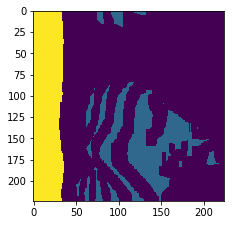

Prev post ang: [52, 54, 90, 90], posterior: 71,  ctr:76


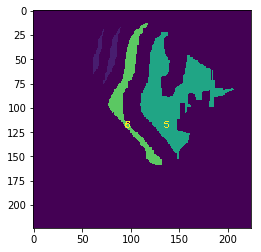

DTYPE: (224, 224)
ctr 77
(dtype('uint8'), True, (224, 224))


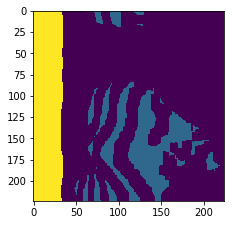

Prev post ang: [52, 52, 90, 90], posterior: 71,  ctr:77


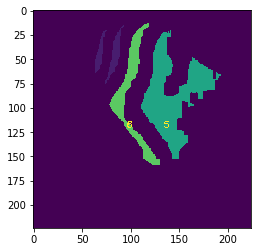

DTYPE: (224, 224)
ctr 78
(dtype('uint8'), True, (224, 224))


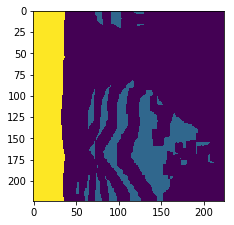

Prev post ang: [52, 52, 52, 90], posterior: 61,  ctr:78
0 NO CHILD!!!
left_orphan: 92
before None check 92, j=0, val=None
before None check 92, j=1, val=None
before None check 92, j=2, val=136
after None check 92
second if 92


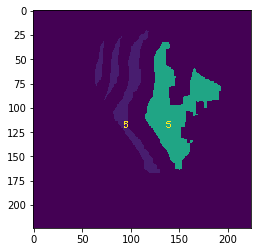

DTYPE: (224, 224)
ctr 79
(dtype('uint8'), True, (224, 224))


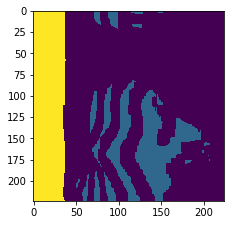

Prev post ang: [52, 52, 52, 85], posterior: 60,  ctr:79


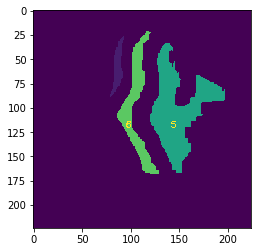

DTYPE: (224, 224)
ctr 80
(dtype('uint8'), True, (224, 224))


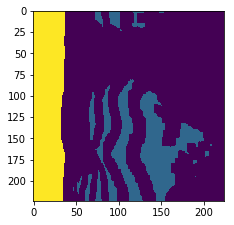

Prev post ang: [51, 52, 52, 85], posterior: 60,  ctr:80


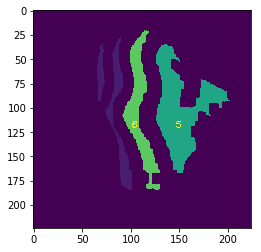

DTYPE: (224, 224)
ctr 81
(dtype('uint8'), True, (224, 224))


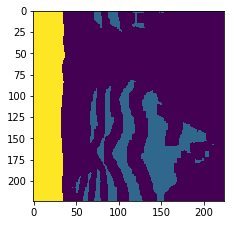

Prev post ang: [51, 51, 52, 85], posterior: 59,  ctr:81


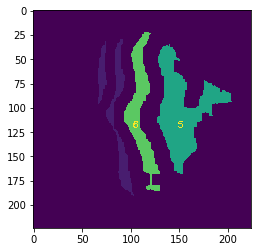

DTYPE: (224, 224)
ctr 82
(dtype('uint8'), True, (224, 224))


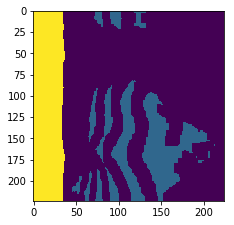

Prev post ang: [51, 51, 52, 85], posterior: 59,  ctr:82


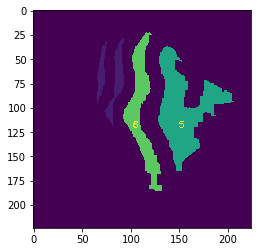

DTYPE: (224, 224)
ctr 83
(dtype('uint8'), True, (224, 224))


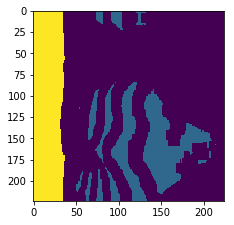

Prev post ang: [51, 51, 52, 52], posterior: 51,  ctr:83
left_orphan: 77
before None check 77, j=0, val=None
before None check 77, j=1, val=101
after None check 77
second if 77


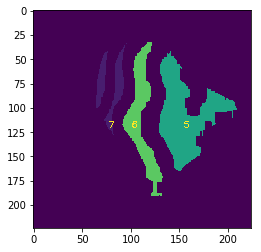

DTYPE: (224, 224)
ctr 84
(dtype('uint8'), True, (224, 224))


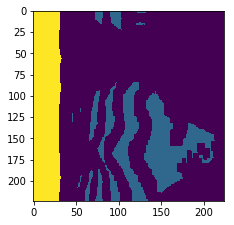

Prev post ang: [52, 51, 52, 52], posterior: 51,  ctr:84


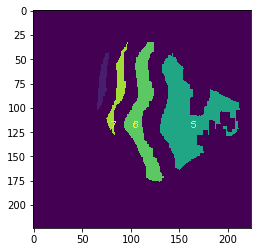

DTYPE: (224, 224)
ctr 85
(dtype('uint8'), True, (224, 224))


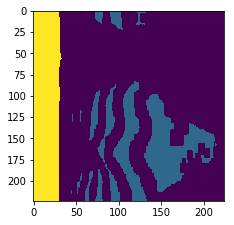

Prev post ang: [52, 53, 52, 52], posterior: 52,  ctr:85


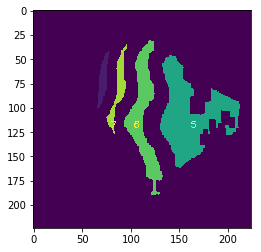

DTYPE: (224, 224)
ctr 86
(dtype('uint8'), True, (224, 224))


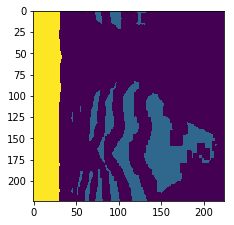

Prev post ang: [52, 53, 52, 52], posterior: 52,  ctr:86


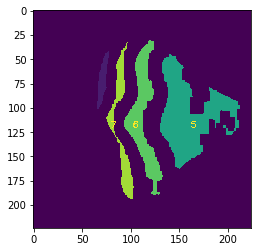

DTYPE: (224, 224)
ctr 87
(dtype('uint8'), True, (224, 224))


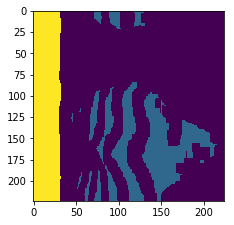

Prev post ang: [52, 53, 52, 53], posterior: 52,  ctr:87


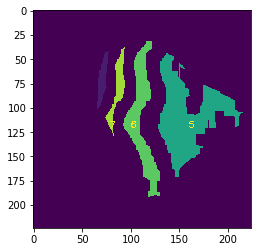

DTYPE: (224, 224)
ctr 88
(dtype('uint8'), True, (224, 224))


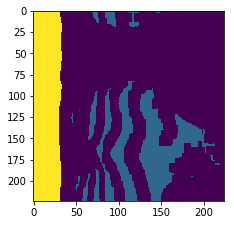

Prev post ang: [51, 53, 52, 53], posterior: 52,  ctr:88


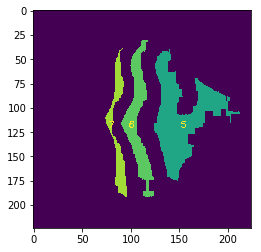

DTYPE: (224, 224)
ctr 89
(dtype('uint8'), True, (224, 224))


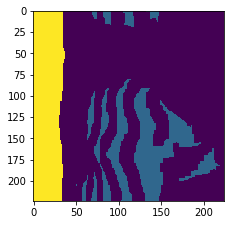

Prev post ang: [51, 86, 52, 53], posterior: 60,  ctr:89
right_orphan: 205


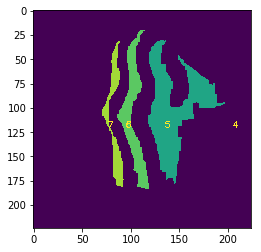

DTYPE: (224, 224)
ctr 90
(dtype('uint8'), True, (224, 224))


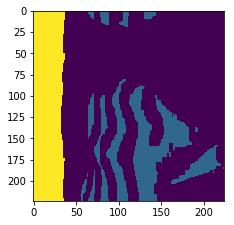

Prev post ang: [51, 86, 87, 53], posterior: 69,  ctr:90
2 NO CHILD!!!
3 NO CHILD!!!
right_orphan: 197


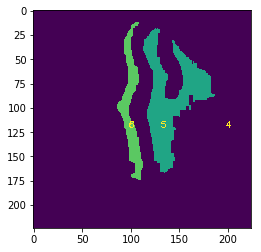

DTYPE: (224, 224)
ctr 91
(dtype('uint8'), True, (224, 224))


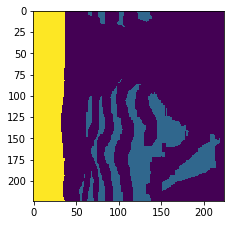

Prev post ang: [51, 86, 87, 88], posterior: 78,  ctr:91


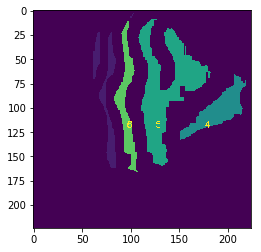

DTYPE: (224, 224)
ctr 92
(dtype('uint8'), True, (224, 224))


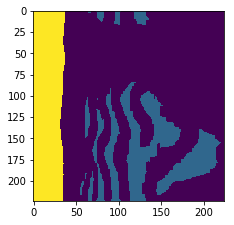

Prev post ang: [51, 86, 87, 88], posterior: 78,  ctr:92


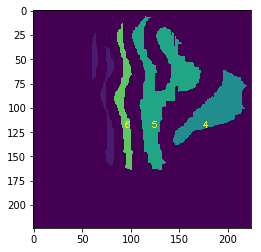

DTYPE: (224, 224)
ctr 93
(dtype('uint8'), True, (224, 224))


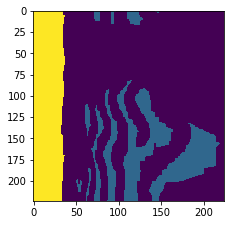

Prev post ang: [51, 89, 87, 88], posterior: 78,  ctr:93
left_orphan: 76
before None check 76, j=0, val=None
before None check 76, j=1, val=91
after None check 76
second if 76


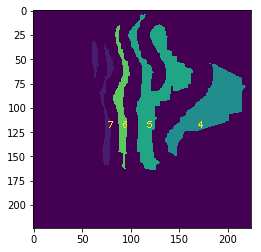

DTYPE: (224, 224)
ctr 94
(dtype('uint8'), True, (224, 224))


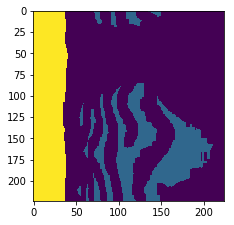

Prev post ang: [51, 89, 52, 88], posterior: 70,  ctr:94
1 NO CHILD!!!
3 NO CHILD!!!
left_orphan: 82
before None check 82, j=0, val=None
before None check 82, j=1, val=None
before None check 82, j=2, val=107
after None check 82
second if 82


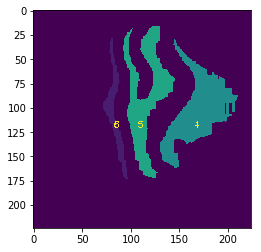

DTYPE: (224, 224)
ctr 95
(dtype('uint8'), True, (224, 224))


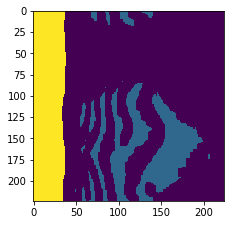

Prev post ang: [51, 89, 52, 52], posterior: 61,  ctr:95
2 NO CHILD!!!
left_orphan: 73
before None check 73, j=0, val=None
before None check 73, j=1, val=None
before None check 73, j=2, val=99
after None check 73
second if 73


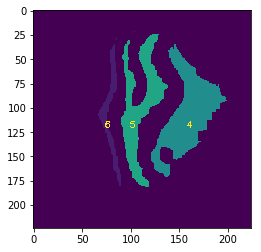

DTYPE: (224, 224)
ctr 96
(dtype('uint8'), True, (224, 224))


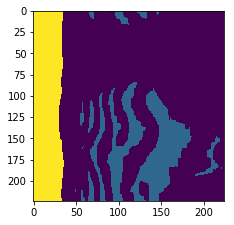

Prev post ang: [51, 89, 52, 52], posterior: 61,  ctr:96


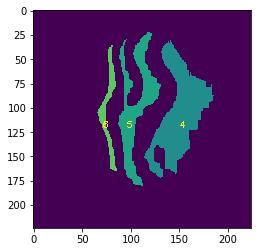

DTYPE: (224, 224)
ctr 97
(dtype('uint8'), True, (224, 224))


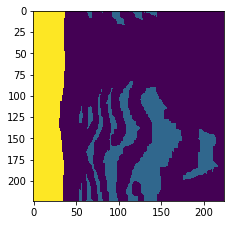

Prev post ang: [51, 52, 52, 52], posterior: 51,  ctr:97
2 NO CHILD!!!
right_orphan: 202
left_orphan: 66
before None check 66, j=0, val=None
before None check 66, j=1, val=None
before None check 66, j=2, val=94
after None check 66
second if 66


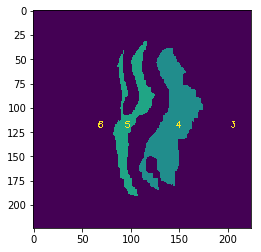

DTYPE: (224, 224)
ctr 98
(dtype('uint8'), True, (224, 224))


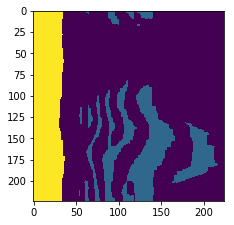

Prev post ang: [51, 52, 53, 52], posterior: 52,  ctr:98
3 NO CHILD!!!
right_orphan: 199


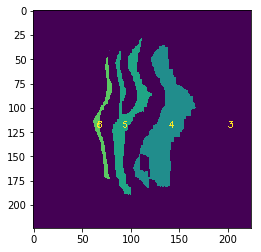

DTYPE: (224, 224)
ctr 99
(dtype('uint8'), True, (224, 224))


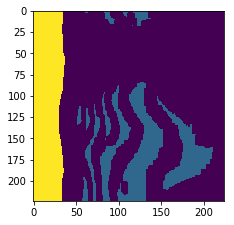

Prev post ang: [51, 52, 53, 52], posterior: 52,  ctr:99


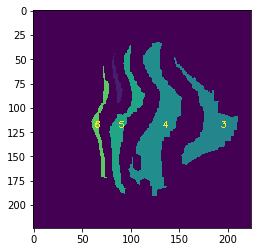

DTYPE: (224, 224)
ctr 100
(dtype('uint8'), True, (224, 224))


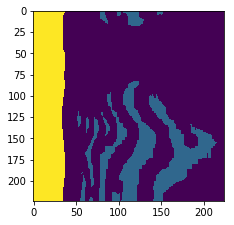

Prev post ang: [51, 52, 53, 52], posterior: 52,  ctr:100


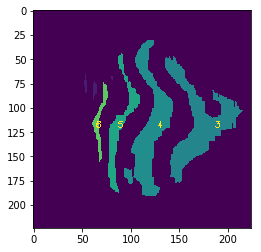

DTYPE: (224, 224)
ctr 101
(dtype('uint8'), True, (224, 224))


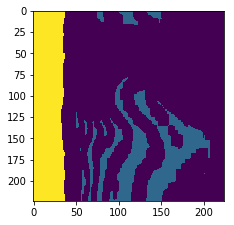

Prev post ang: [51, 85, 53, 52], posterior: 60,  ctr:101


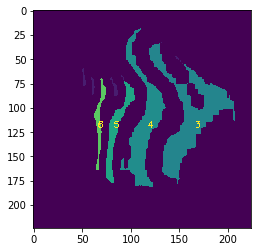

DTYPE: (224, 224)
ctr 102
(dtype('uint8'), True, (224, 224))


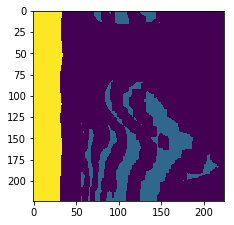

Prev post ang: [51, 85, 50, 52], posterior: 59,  ctr:102
right_orphan: 206


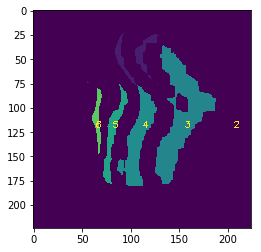

DTYPE: (224, 224)
ctr 103
(dtype('uint8'), True, (224, 224))


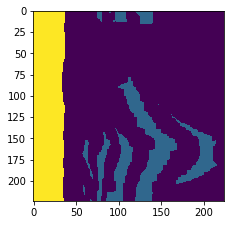

Prev post ang: [51, 85, 50, 50], posterior: 59,  ctr:103
4 NO CHILD!!!
right_orphan: 202


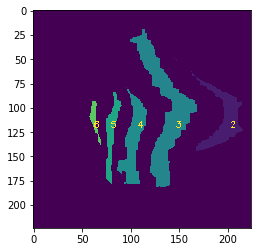

DTYPE: (224, 224)
ctr 104
(dtype('uint8'), True, (224, 224))


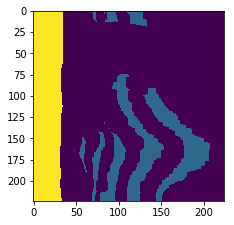

Prev post ang: [47, 85, 50, 50], posterior: 58,  ctr:104
2 NO CHILD!!!
4 NO CHILD!!!
right_orphan: 189


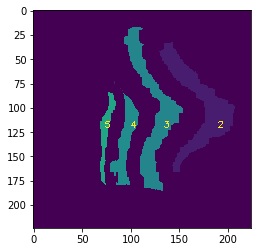

DTYPE: (224, 224)
ctr 105
(dtype('uint8'), True, (224, 224))


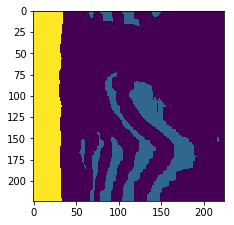

Prev post ang: [47, 46, 50, 50], posterior: 48,  ctr:105
left_orphan: 57
before None check 57, j=0, val=None
before None check 57, j=1, val=None
before None check 57, j=2, val=75
after None check 57
second if 57


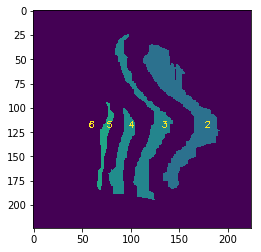

DTYPE: (224, 224)
ctr 106
(dtype('uint8'), True, (224, 224))


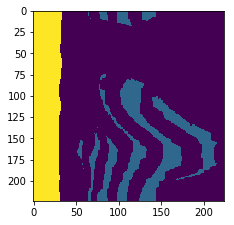

Prev post ang: [47, 46, 80, 50], posterior: 55,  ctr:106
right_orphan: 204


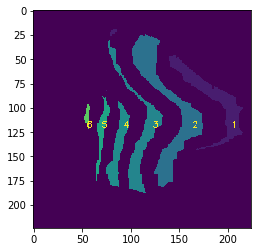

DTYPE: (224, 224)
ctr 107
(dtype('uint8'), True, (224, 224))


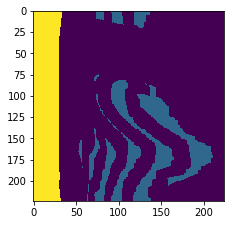

Prev post ang: [47, 46, 80, 51], posterior: 56,  ctr:107
5 NO CHILD!!!
right_orphan: 196


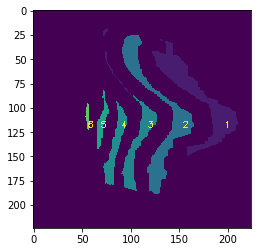

DTYPE: (224, 224)
ctr 108
(dtype('uint8'), True, (224, 224))


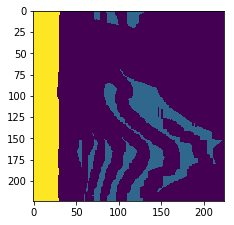

Prev post ang: [50, 46, 80, 51], posterior: 56,  ctr:108


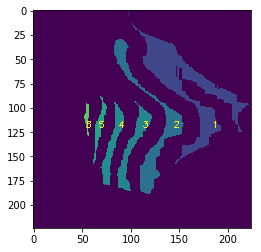

DTYPE: (224, 224)
ctr 109
(dtype('uint8'), True, (224, 224))


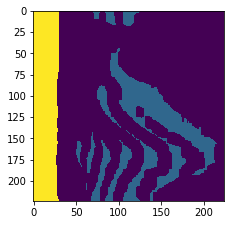

Prev post ang: [50, 35, 80, 51], posterior: 54,  ctr:109


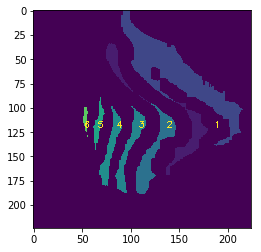

DTYPE: (224, 224)
ctr 110
(dtype('uint8'), True, (224, 224))


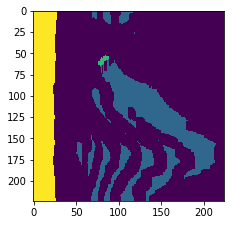

Prev post ang: [50, 35, 39, 51], posterior: 43,  ctr:110
4 NO CHILD!!!
left_orphan: 54
before None check 54, j=0, val=None
before None check 54, j=1, val=None
before None check 54, j=2, val=70
after None check 54
second if 54


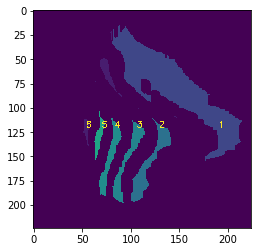

DTYPE: (224, 224)
ctr 111
(dtype('uint8'), True, (224, 224))


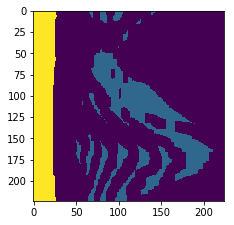

Prev post ang: [50, 35, 39, 40], posterior: 41,  ctr:111


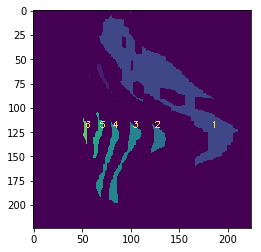

DTYPE: (224, 224)
ctr 112
(dtype('uint8'), True, (224, 224))


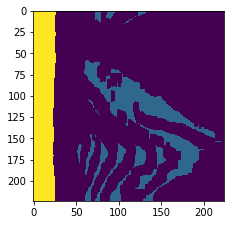

Prev post ang: [37, 35, 39, 40], posterior: 37,  ctr:112
3 NO CHILD!!!


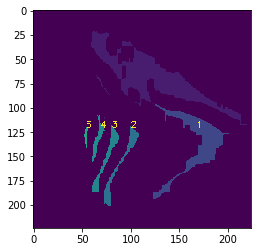

DTYPE: (224, 224)
ctr 113
(dtype('uint8'), True, (224, 224))


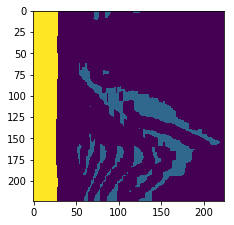

Prev post ang: [37, 38, 39, 40], posterior: 38,  ctr:113
right_orphan: 210


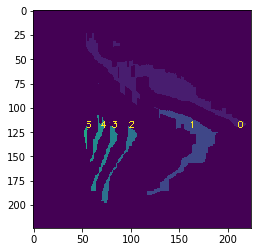

DTYPE: (224, 224)
ctr 114
(dtype('uint8'), True, (224, 224))


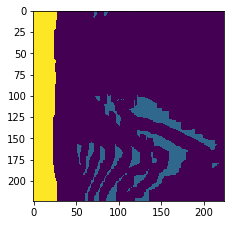

Prev post ang: [37, 38, 54, 40], posterior: 42,  ctr:114
1 NO CHILD!!!
2 NO CHILD!!!
4 NO CHILD!!!


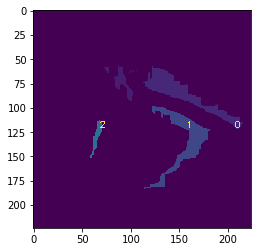

DTYPE: (224, 224)
ctr 115
(dtype('uint8'), True, (224, 224))


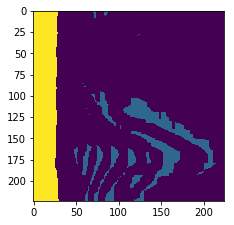

Prev post ang: [37, 38, 54, 52], posterior: 45,  ctr:115


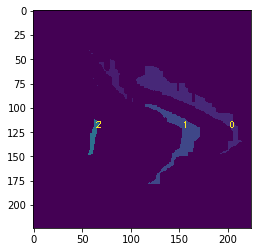

DTYPE: (224, 224)
ctr 116
(dtype('uint8'), True, (224, 224))


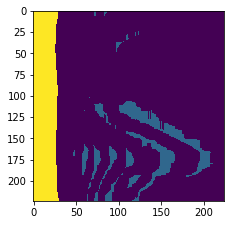

Prev post ang: [74, 38, 54, 52], posterior: 54,  ctr:116
MIDDLE BLOB BEING INSERTED cX: 75
MIDDLE BLOB BEING INSERTED cX: 93
MIDDLE BLOB BEING INSERTED cX: 112


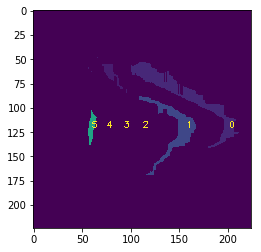

DTYPE: (224, 224)
ctr 117
(dtype('uint8'), True, (224, 224))


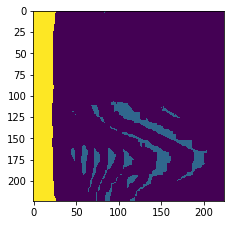

Prev post ang: [74, 54, 54, 52], posterior: 58,  ctr:117


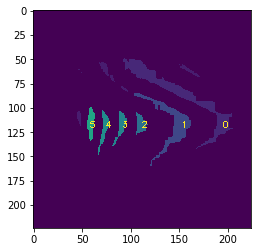

DTYPE: (224, 224)
ctr 118
(dtype('uint8'), True, (224, 224))


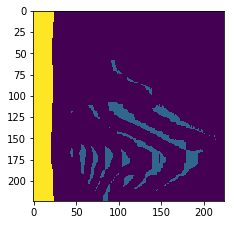

Prev post ang: [74, 54, 215, 52], posterior: 98,  ctr:118
0 NO CHILD!!!
2 NO CHILD!!!
3 NO CHILD!!!
5 NO CHILD!!!


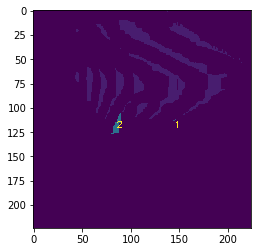

DTYPE: (224, 224)
ctr 119
(dtype('uint8'), True, (224, 224))


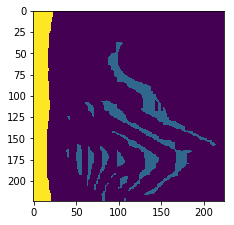

Prev post ang: [74, 54, 215, 218], posterior: 140,  ctr:119
0 NO CHILD!!!
1 NO CHILD!!!
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 120
(dtype('uint8'), True, (224, 224))


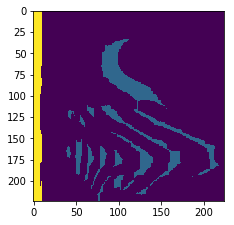

Prev post ang: [220, 54, 215, 218], posterior: 176,  ctr:120
DTYPE: (224, 224)
ctr 121
(dtype('uint8'), True, (224, 224))


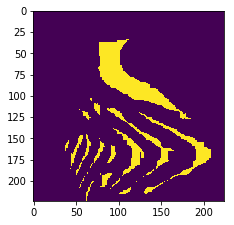

Prev post ang: [220, 220, 215, 218], posterior: 218,  ctr:121
right_orphan: 152


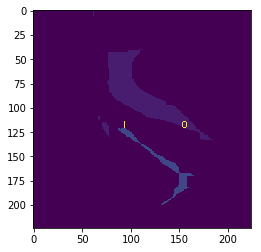

DTYPE: (224, 224)
ctr 122
(dtype('uint8'), True, (224, 224))


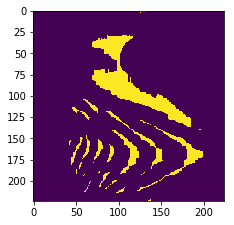

Prev post ang: [220, 220, 219, 218], posterior: 219,  ctr:122
0 NO CHILD!!!
1 NO CHILD!!!
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 123
(dtype('uint8'), True, (224, 224))


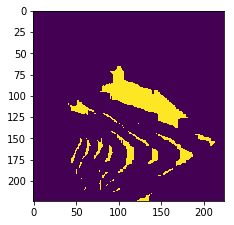

Prev post ang: [220, 220, 219, 215], posterior: 218,  ctr:123
DTYPE: (224, 224)
ctr 124
(dtype('uint8'), True, (224, 224))


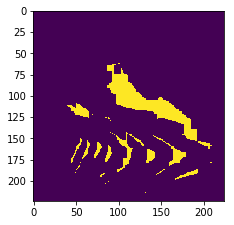

Prev post ang: [210, 220, 219, 215], posterior: 216,  ctr:124


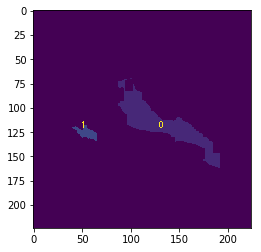

DTYPE: (224, 224)
ctr 125
(dtype('uint8'), True, (224, 224))


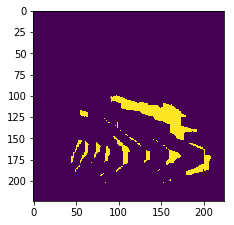

Prev post ang: [210, 209, 219, 215], posterior: 213,  ctr:125
1 NO CHILD!!!


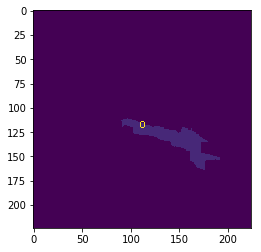

DTYPE: (224, 224)
ctr 126
(dtype('uint8'), True, (224, 224))


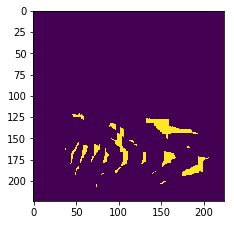

Prev post ang: [210, 209, 209, 215], posterior: 210,  ctr:126
0 NO CHILD!!!
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 127
(dtype('uint8'), True, (224, 224))


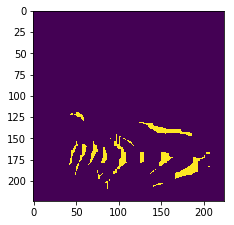

Prev post ang: [210, 209, 209, 214], posterior: 210,  ctr:127
DTYPE: (224, 224)
ctr 128
(dtype('uint8'), True, (224, 224))


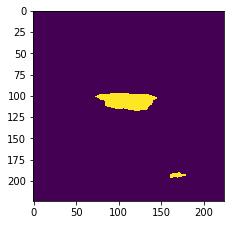

Prev post ang: [210, 209, 209, 214], posterior: 210,  ctr:128
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 129
(dtype('uint8'), True, (224, 224))


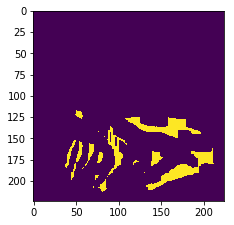

Prev post ang: [210, 217, 209, 214], posterior: 212,  ctr:129
DTYPE: (224, 224)
ctr 130
(dtype('uint8'), True, (224, 224))


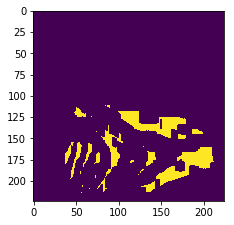

Prev post ang: [210, 217, 218, 214], posterior: 214,  ctr:130
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 131
(dtype('uint8'), True, (224, 224))


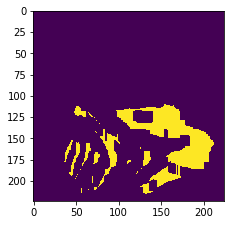

Prev post ang: [210, 217, 218, 219], posterior: 216,  ctr:131
DTYPE: (224, 224)
ctr 132
(dtype('uint8'), True, (224, 224))


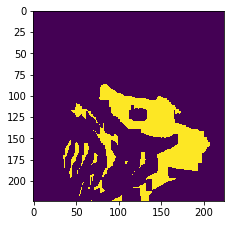

Prev post ang: [43, 217, 218, 219], posterior: 174,  ctr:132
0 NO CHILD!!!
1 NO CHILD!!!
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 133
(dtype('uint8'), True, (224, 224))


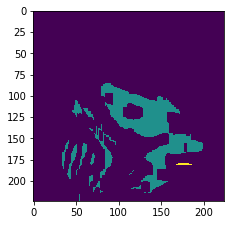

Prev post ang: [43, 219, 218, 219], posterior: 174,  ctr:133
DTYPE: (224, 224)
ctr 134
(dtype('uint8'), True, (224, 224))


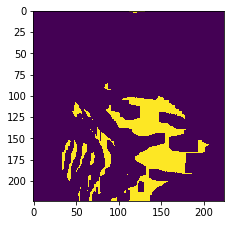

Prev post ang: [43, 219, 98, 219], posterior: 144,  ctr:134
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 135
(dtype('uint8'), True, (224, 224))


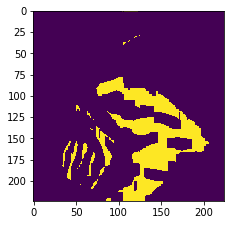

Prev post ang: [43, 219, 98, 40], posterior: 100,  ctr:135
DTYPE: (224, 224)
ctr 136
(dtype('uint8'), True, (224, 224))


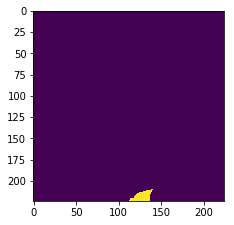

Prev post ang: [105, 219, 98, 40], posterior: 115,  ctr:136
0 NO CHILD!!!
1 NO CHILD!!!
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 137
(dtype('uint8'), True, (224, 224))


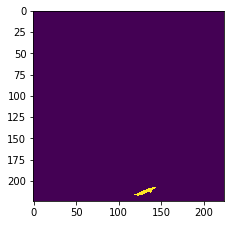

Prev post ang: [105, 220, 98, 40], posterior: 115,  ctr:137
DTYPE: (224, 224)
ctr 138
(dtype('uint8'), True, (224, 224))


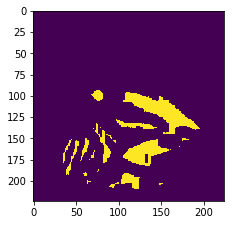

Prev post ang: [105, 220, 217, 40], posterior: 145,  ctr:138
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 139
(dtype('uint8'), True, (224, 224))


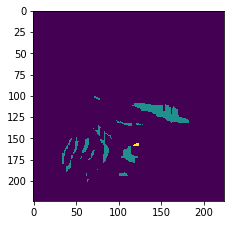

Prev post ang: [105, 220, 217, 209], posterior: 187,  ctr:139
DTYPE: (224, 224)
ctr 140
(dtype('uint8'), True, (224, 224))


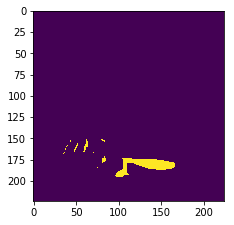

Prev post ang: [210, 220, 217, 209], posterior: 214,  ctr:140
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 141
(dtype('uint8'), True, (224, 224))


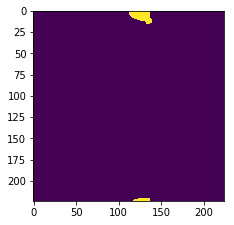

Prev post ang: [210, 117, 217, 209], posterior: 188,  ctr:141
DTYPE: (224, 224)
ctr 142
(dtype('uint8'), True, (224, 224))


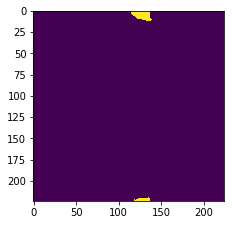

Prev post ang: [210, 117, 116, 209], posterior: 163,  ctr:142
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 143
(dtype('uint8'), True, (224, 224))


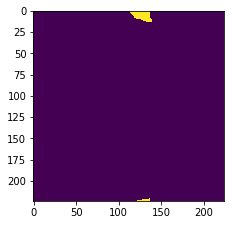

Prev post ang: [210, 117, 116, 118], posterior: 140,  ctr:143
DTYPE: (224, 224)
ctr 144
(dtype('uint8'), True, (224, 224))


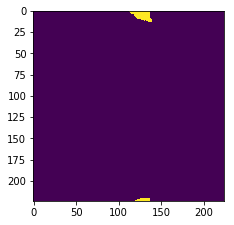

Prev post ang: [117, 117, 116, 118], posterior: 117,  ctr:144
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 145
(dtype('uint8'), True, (224, 224))


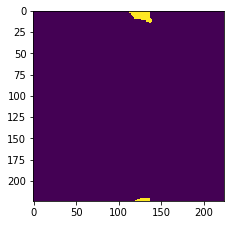

Prev post ang: [117, 117, 116, 118], posterior: 117,  ctr:145
DTYPE: (224, 224)
ctr 146
(dtype('uint8'), True, (224, 224))


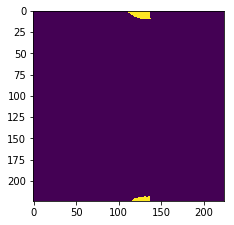

Prev post ang: [117, 117, 114, 118], posterior: 116,  ctr:146


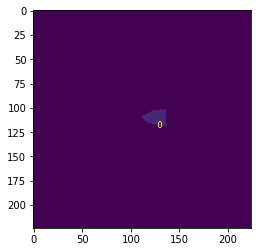

DTYPE: (224, 224)
ctr 147
(dtype('uint8'), True, (224, 224))


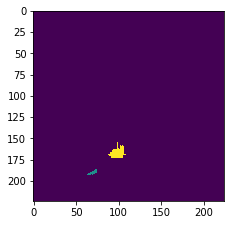

Prev post ang: [117, 117, 114, 208], posterior: 139,  ctr:147
0 NO CHILD!!!
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 148
(dtype('uint8'), True, (224, 224))


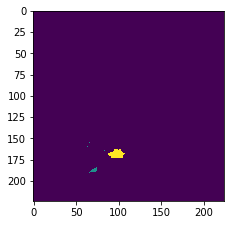

Prev post ang: [207, 117, 114, 208], posterior: 161,  ctr:148
DTYPE: (224, 224)
ctr 149
(dtype('uint8'), True, (224, 224))


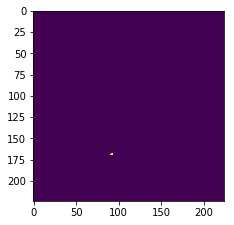

Prev post ang: [207, 112, 114, 208], posterior: 160,  ctr:149
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 150
(dtype('uint8'), True, (224, 224))


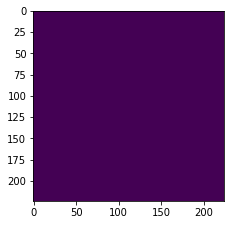

Prev post ang: [207, 112, 112, 208], posterior: 159,  ctr:150
DTYPE: (224, 224)
ctr 151
(dtype('uint8'), True, (224, 224))


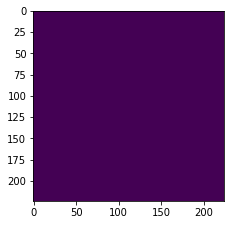

Prev post ang: [207, 112, 112, 112], posterior: 135,  ctr:151
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 152
(dtype('uint8'), True, (224, 224))


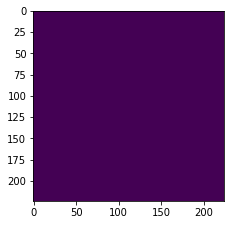

Prev post ang: [112, 112, 112, 112], posterior: 112,  ctr:152
DTYPE: (224, 224)
ctr 153
(dtype('uint8'), True, (224, 224))


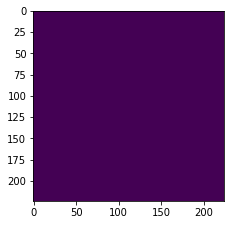

Prev post ang: [112, 112, 112, 112], posterior: 112,  ctr:153
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 154
(dtype('uint8'), True, (224, 224))


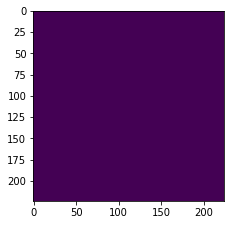

Prev post ang: [112, 112, 112, 112], posterior: 112,  ctr:154
DTYPE: (224, 224)
ctr 155
(dtype('uint8'), True, (224, 224))


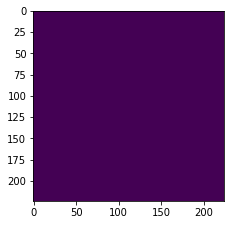

Prev post ang: [112, 112, 112, 112], posterior: 112,  ctr:155
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 156
(dtype('uint8'), True, (224, 224))


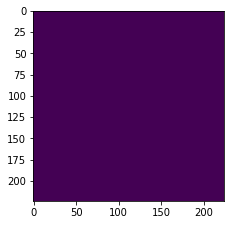

In [ ]:
clear_output()
print ("Starting!")

#For finding posterior region
posterior_region_ctr = 0
prev_posterior_angles = [int(224/4),int(224/4),int(224/4),int(224/4)]
#endof For finding posterior region


#For tracking
tracker=None
#endof For tracking
ctr=0
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    print("ctr {}".format(ctr))
    
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break
    
    # Perform inference
    mask = inference(frame)

    # Convert from linear to polar
    polar_image = unwrap_image(mask)

    # Clean up linear image
    clean_img = cv2.erode(polar_image,np.ones((11,1)))
#     clean_flattened_timeline.append((clean_img,(cX,cY)))
    
    #Finding posterior region
    posterior, prev_posterior_angles, posterior_region_ctr = find_posterior_region(clean_img, prev_posterior_angles, posterior_region_ctr)
    mask_continuous = get_posterior_corrected_frame(clean_img, posterior)
    print((mask_continuous.dtype,isinstance(mask_continuous,(np.ndarray)),mask_continuous.shape))
#     import pdb; pdb.set_trace()
    
    #Tracking
#     clear_output(wait=True)
    pltimg(clean_img)
    print("Prev post ang: {}, posterior: {},  ctr:{}".format(prev_posterior_angles, posterior, posterior_region_ctr))
    img = mask_continuous==1
    if tracker is None:
        tracker=Tracker(init_frame=img)
    else:
        success = tracker.iterate(img)
        #Restart tracker from next frame if tracker is not successful
        if not success: tracker = None
    print("DTYPE: {}".format(img.shape))

    if DEBUG_MODE:
        #Tests for optimal erosion level
        e_list = []
        for num in range(5,12):
            e = cv2.erode(polar_image,np.ones((num,1)))
            e_list.append(e)
        eroded_timeline.append(e_list)
        
        # Cleaned up linear image
        linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
        clean_timeline.append(linear_image)
    
cap.release()
# out.release()
print ("End!")

In [36]:
if isinstance(mask_continuous,(np.ndarray)):
        print("HI")

HI


## Finding the posterior region

In [26]:
mask_continuous_timeline = []

Posterior angle: 112 from 114
199


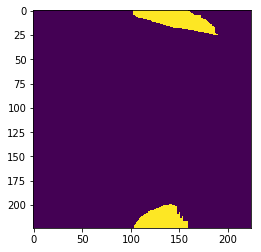

In [27]:
# posterior_region_ctr = 0
# prev_posterior_angles = [int(224/4),int(224/4),int(224/4),int(224/4)]

for mask, frame in zip(clean_flattened_timeline[71:], frame_timeline[71:]):
        
    frame_copy = frame.copy()
    frame_copy = cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    centreX, centreY = frame.shape[0]/2.0, frame.shape[1]/2.0

    L1 = 75
    L2 = 100
    
    p1 = np.round((centreX+L1*math.cos(posterior_angle),centreY+L1*math.sin(posterior_angle))).astype(np.int)
    p2 = np.round((centreX+L2*math.cos(posterior_angle),centreY+L2*math.sin(posterior_angle))).astype(np.int)
    cv2.arrowedLine(frame_copy, tuple(p1),tuple(p2), (255,0,0),3)
    
    
    mask_continuous_timeline.append(mask_continuous)

    
    print(ctr)
    
    if DEBUG_MODE:
        plt.imshow(mask_continuous)
        plt.show()
    time.sleep(1)
    clear_output(wait=True)
#####################

In [23]:
# while cap.isOpened():
#     r,f = capture.read()
#     pltimg(f)

## Tracking from scratch

TODO: Implement blob wise intersection. The corresponding blobs in frame t+1 will be the one that the current blob has the largest intersection with.

Should really work. Try!

In [71]:
hist = np.array([])
longest_contiguous_region(hist <5, hist)

IndexError: index 0 is out of bounds for axis 0 with size 0

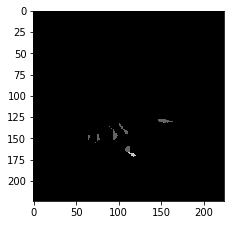

from find_posterior_region


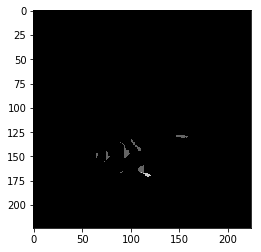

ValueError: too many values to unpack (expected 1)

In [63]:
## Tracking only the mid sections!
# capture = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
r, f = cap.read()
tracker = Tracker(init_frame=f)
###INIT FOR FIRST FRAME

for (i, img) in enumerate(mask_continuous_timeline[2:]):
    ret, frame = tracker.cap.read()
    pltimg(frame)
    tracker.iterate(frame)


In [201]:
%debug

> <ipython-input-200-ddb99f3852dd>(1)<module>()
----> 1 numbers_frame.shape

ipdb> numbers_frame.shape
*** NameError: name 'numbers_frame' is not defined
ipdb> numbers_frame
*** NameError: name 'numbers_frame' is not defined
ipdb> blobs[0].shape
*** NameError: name 'blobs' is not defined
ipdb> q


In [192]:
# cv2.cvtColor(cimg.ex, cv2.COLOR_BGR2HSV)
np.expand_dims(cimg,0).shape

(1, 224, 224)

In [146]:
last_values, get_non_None_section(last_values)

([], (0, -1))

In [147]:
# len(mid_blob_tracks)
mid_blob_tracks

[]

> <ipython-input-44-8725fc2fc189>(66)correlate_blobs()
     64         for p in range(0,len(prev_blobs)):
     65             pblob = prev_blobs[p]
---> 66             intersect = cv2.bitwise_and(nblob, pblob)
     67 
     68             if blob_area(intersect) > max_intercept:

ipdb> np.shape(mid_new)
(7, 10, 224)
ipdb> np.shape(mid_prev)
(3, 10, 224)
ipdb> pltimg(mid_new[0])


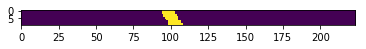

ipdb> pltimg(mid_new[1])


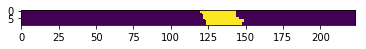

ipdb> pltimg(mid_new[2])


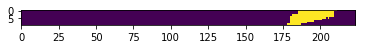

ipdb> pltimg(mid_new[3])


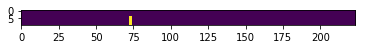

ipdb> pltimg(mid_new[4])


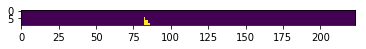

ipdb> pltimg(mid_new[5])


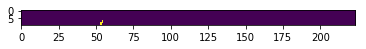

ipdb> pltimg(mid_new[6])


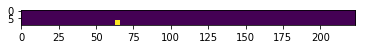

ipdb> pltimg(mid_new[7])
*** IndexError: list index out of range
ipdb> pltimg(mid_prev[0])


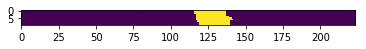

ipdb> pltimg(mid_prev[1])


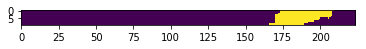

ipdb> pltimg(mid_prev[2])


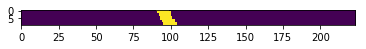

ipdb> pltimg(mid_prev[3])
*** IndexError: list index out of range
ipdb> pltimg(n_blob)
*** NameError: name 'n_blob' is not defined
ipdb> pltimg(nblob)


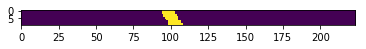

ipdb> pltimg(pblob)


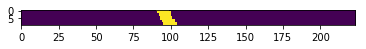

ipdb> nblob.dtype
dtype('uint8')
ipdb> pblob.dtype
dtype('int32')
ipdb> cv2.bitwise_and(nblob,pblob)
*** cv2.error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/core/src/arithm.cpp:223: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'
ipdb> cv2.bitwise_and(nblob,pblob.astype(np.uint8)
*** SyntaxError: unexpected EOF while parsing
ipdb> cv2.bitwise_and(nblob,pblob.astype(np.uint8))
array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)
ipdb> np.unique(cv2.bitwise_and(nblob,pblob.astype(np.uint8)))
array([  0, 255], dtype=uint8)
ipdb>

In [127]:
%debug

In [99]:
# contiguous_regions([False,False,True,True,False,True,False])
l = [False,2,3,False,5,False]
l3 = [1,None,None,4,None,6]
# regs = contiguous_regions(l);regs

l2=[]
for j,val in enumerate(l):
    if val is False:
        l2=l2+[l3[j]]
# for val in l:
#     l2+=[
print(l2)
# l2 = l[0:regs[0][0]]
# for section in regs:
#     l2 = l2+l[section[0]:section[1]]

[1, 4, 6]


In [100]:
[val is None for val in [track[-1] for track in mid_blob_tracks][start_none: end_none+1]]

[False, True, False]

In [103]:
%debug

> <ipython-input-102-1207723cfc30>(51)<listcomp>()
     49         M_prev = cv2.moments((m[1]>0).astype(np.uint8))
     50         cX_prev = int(M_prev["m10"] / M_prev["m00"])
---> 51         last_values = [track[-1] for track in mid_blob_tracks]
     52 
     53         if blob_area(m[0])>0: #non-empty child

ipdb> temp_tracks
[86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127, 133, 134, 53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95]
ipdb> q


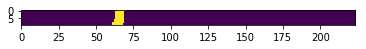

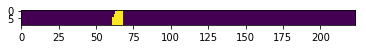

In [142]:
img = img==1
    
#Find all blobs in current frame
blobs_current = get_blobs_single_class(img, label_value=255)
mid_new = get_middle_section(blobs_current, collapse_channels=False)
pltimg(mid_new[5])
    
#Find all blobs in current frame
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
mid_prev = get_middle_section(blobs_prev, collapse_channels=False)
pltimg(mid_prev[4])

n, o = correlate_blobs([mid_new[5]], [mid_prev[4]], orphan_min_area=0)

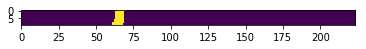

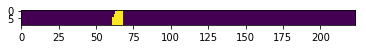

(1, 2, 10, 224)


In [143]:
pltimg(n[0][0])
pltimg(n[0][1])
print(np.shape(n))
# np.shape(mid_prev)

In [109]:
%debug

> <ipython-input-108-c37cb91e9cc4>(50)<listcomp>()
     48         M_prev = cv2.moments((m[1]>0).astype(np.uint8))
     49         cX_prev = int(M_prev["m10"] / M_prev["m00"])
---> 50         last_values = [track[-1] for track in mid_blob_tracks]
     51 
     52         if blob_area(m[0])>0: #non-empty child

ipdb> mid_blob_tracks
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212], [142, 149, 151, 155, 161, 164, 170], [110, 116, 117, 121, 125, 127, 130], [86, 90, 91, 94, 96, 98, 100], [66, 70, 71, 73, 75, 76, 77], [53, 55, 55, 57, 59, 59, 61], 53]
ipdb> q


TypeError: Invalid dimensions for image data

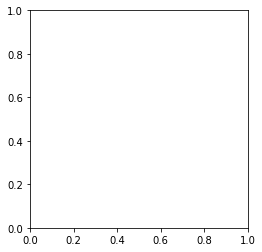

In [66]:
pltimg(mid_new)
pltimg(mid_prev)
# new_blobs, orphans=  correlate_blobs(blobs_prev[3],blobs_prev[3])

In [65]:
%debug

> /opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py(646)set_data()
    644         if not (self._A.ndim == 2
    645                 or self._A.ndim == 3 and self._A.shape[-1] in [3, 4]):
--> 646             raise TypeError("Invalid dimensions for image data")
    647 
    648         if self._A.ndim == 3:

ipdb> mid_blob_tracks
*** NameError: name 'mid_blob_tracks' is not defined
ipdb> mid_blob_tracks
*** NameError: name 'mid_blob_tracks' is not defined
ipdb> q


In [147]:
colours = np.linspace(10,249,40).astype(np.uint8)

# index = random.randint(0,len(colours)-1)
np.random.shuffle(colours)
last = colours[-1]
last

242

/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:386: RuntimeWarning: invalid value encountered in true_divide
  overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*colour).astype(np.uint8)


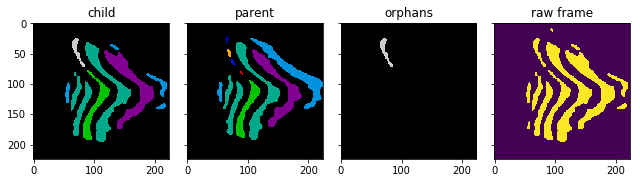

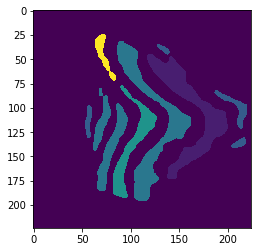

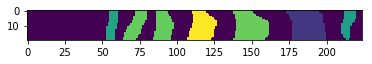

1


/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:388: RuntimeWarning: invalid value encountered in true_divide
  overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colour).astype(np.uint8)


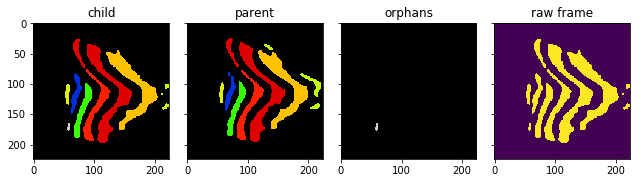

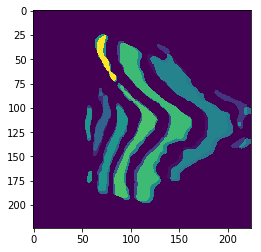

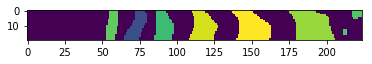

2


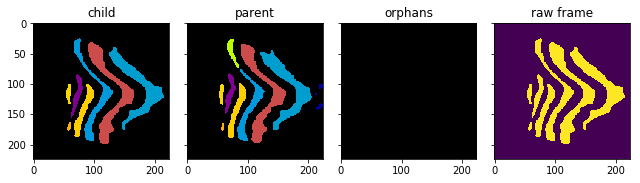

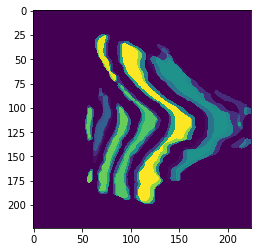

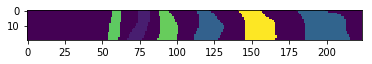

3


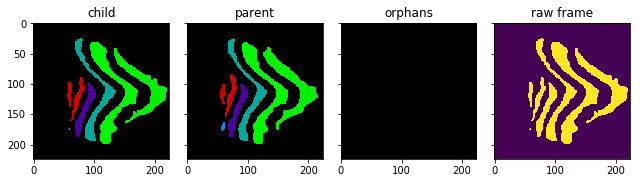

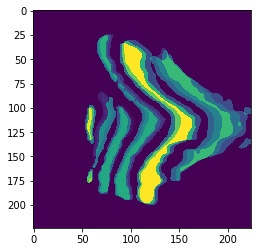

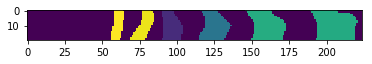

4


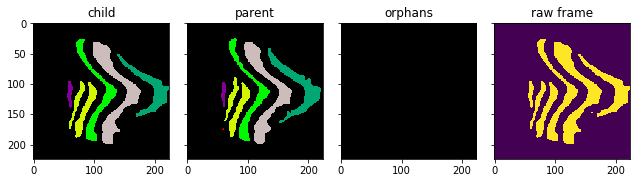

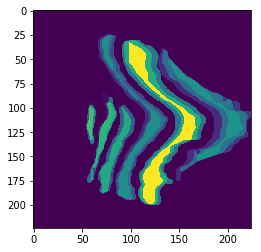

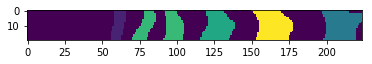

5


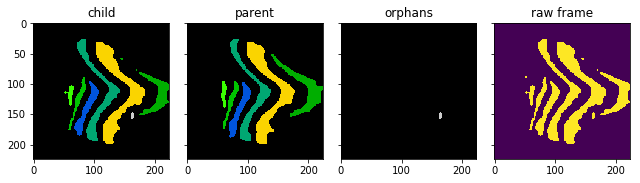

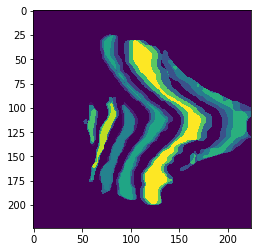

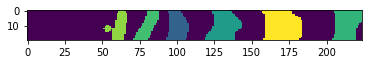

6


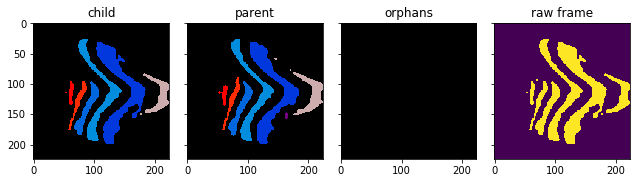

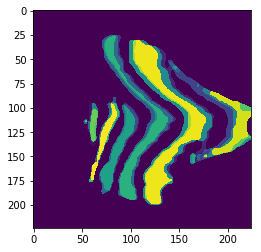

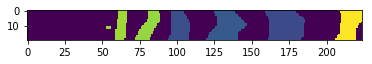

7


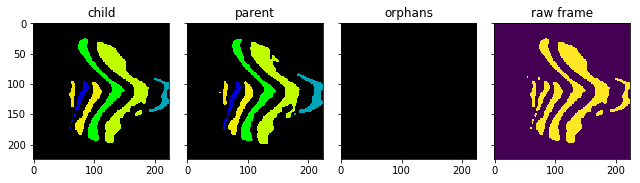

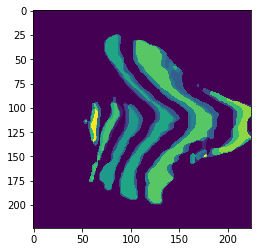

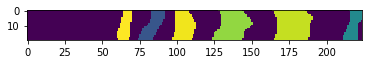

8


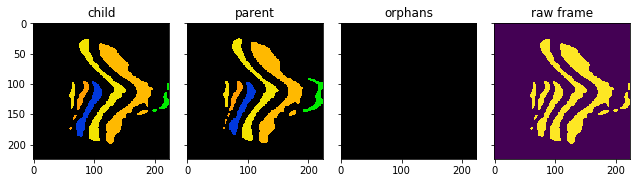

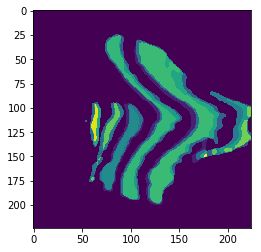

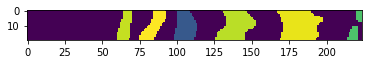

9


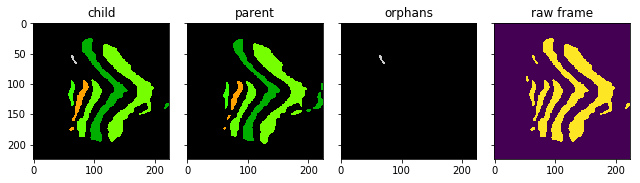

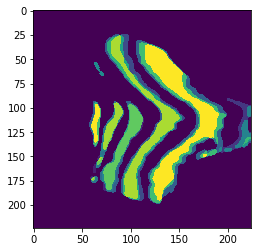

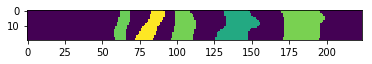

10


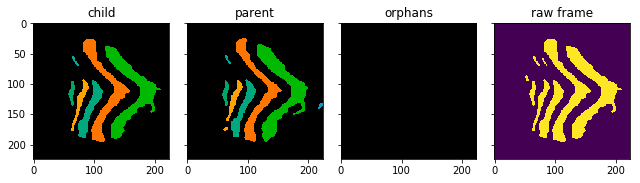

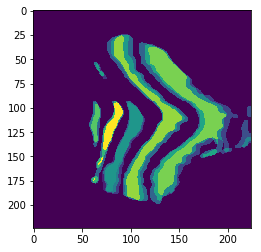

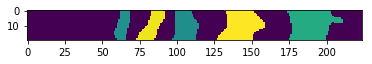

11


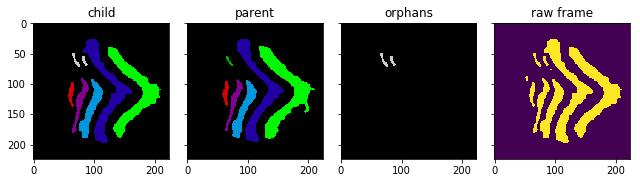

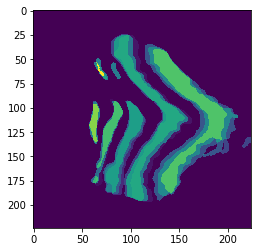

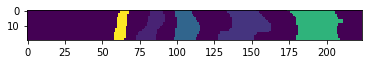

12


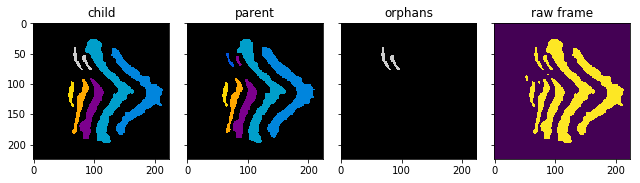

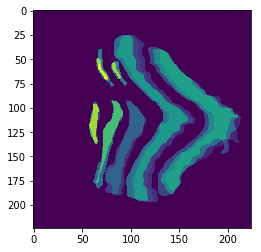

KeyboardInterrupt: 

In [65]:
## TEST ONE!!!

verbose = False
prev_frame = clean_blobs[0]
# prev_frame = avg_frames([mask_continuous_timeline[2],mask_continuous_timeline[1],mask_continuous_timeline[0]])
# prev_frame = clean_blobs[0]==255
# pltimg(prev_frame)
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
cnt = 0

# for img in clean_blobs:
prev_children = [np.zeros_like(clean_blobs[0]),np.zeros_like(clean_blobs[0]),np.zeros_like(clean_blobs[0])]
show_overlap = True
for (i, img) in enumerate(clean_blobs[2:]):
#     img = img==1

    #Attempt at averaging stuff
#     img = avg_frames([mask_continuous_timeline[i-2],mask_continuous_timeline[i-1],mask_continuous_timeline[i]])
#     pltimg(img)
#     pltimg(prev_frame)

#     clear_output(wait=True)
#     print("counter: {}".format(cnt))
    cnt +=1
    
    #Find blobs
    blobs_current = get_blobs_single_class(img, label_value=255)
#     blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
    
    #Correlate children to parent blobs
    # blobs_new has the joined blobs with indices corresponding to their parents
    blobs_new, orphans = correlate_blobs(blobs_current, blobs_prev)
    
    if blobs_new is None:
        print("EMPTY!!")
#     print("blobs_new shape {}".format(np.shape(blobs_new)))
#     test_img = (blobs_new[0][0]/np.max(blobs_new[0][0])).astype(np.uint8) | (np.zeros_like(blobs_new[0][0]))
#     pltimg(blobs_new[cnt-1][0])
#     print("done test {}   {}".format(np.unique((blobs_new[0][0]/np.max(blobs_new[0][0])).astype(np.uint8)), np.unique(test_img)))
    
    #######WRONG! Cant just re-find blobs!!!! ...but it works.......
    #Collapse all new blobs into a single frame to make it "prev_frame" for the next iteration
#     blobs_new_frame = collapse_all_channels(blobs_new)   
#     blobs_prev = get_blobs_single_class(blobs_new_frame, label_value=255)
    
    #Add orphans to blobs_prev, so they can become parents in the next iteration
    #Note: this happens AFTER children have already found their parents
    blobs_prev = [blob_[0] for blob_ in blobs_new]
    orphan_imgs = [np.array(o[0]).astype(np.int32) for o in orphans]
    blobs_prev = blobs_prev+orphan_imgs
    
#     pltimg(img)
    children = plot_blob_generations(blobs_new, orphans, include_orphans=True, frame=img)
    
    if show_overlap: #Shows overlap of the past 3 frames. Good way of judging how difficult tracking will be
        prev_children[cnt%3] = children
        pltimg(prev_children[0]+prev_children[1]+prev_children[2])#   ---   (prev_children[cnt%3]+children)/np.max(prev_children[cnt%3]+children)
        pltimg(children[102:122,:])
#     if cnt ==5:
#         break
    
    prev_frame = img
    
    if verbose:
#         plt.imshow(intersect)
#         plt.show()

        fig=plt.figure(figsize=(24,24))
        columns = 3
        rows = 1

        # for c in range (71,100):
        imgs = [intersect,img, img-intersect]
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i-1])
        #     clear_output()
        plt.show()
    print(cnt)
#     time.sleep(0.5)
    
    